# Librerías

In [1]:
# Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Warnings
import warnings;
warnings.simplefilter('ignore')

# Path
ROOT_PATH = os.path.abspath(os.path.join('../' + os.path.dirname('__file__')))

# Funciones

In [2]:
def transform_data(df, binary = False):
    if binary == True:
        list_columns = list(df.columns)
        for col in list_columns:
            col_temp = []
            for i in range(len(df)):
                if df[col].iloc[i] <= 0:
                    col_temp.append(0)
                else:
                    col_temp.append(1)
            df[col] = col_temp
    return df            

In [3]:
# Función para detectar outliers
def detect_outliers(column):
    # Calcular el límite inferior y superior usando la regla empírica
    lower_limit = column.mean() - 2*column.std()
    upper_limit = column.mean() + 2*column.std()
    
    # Devolver una máscara booleana que indica si cada valor es un outlier o no
    return (column < lower_limit) | (column > upper_limit)

In [4]:
def df_outlier(outlier_df, df_OG):
    df_nooutlier = outlier_df.copy()
    list_columns = list(outlier_df.columns)
    for col in list_columns:
        col_temp = []
        col_temp_2 = []
        for i in range(len(outlier_df)):
            if outlier_df[col].iloc[i] == False:
                col_temp.append(np.nan)
                col_temp_2.append(df_OG[col].iloc[i])
            else:
                col_temp.append(df_OG[col].iloc[i])
                col_temp_2.append(np.nan)
        outlier_df[col] = col_temp
        df_nooutlier[col] = col_temp_2
    for f in list(df_nooutlier.columns):
        df_nooutlier[f] = df_nooutlier[f].interpolate(method='linear', axis=0).ffill().bfill()
    return outlier_df, df_nooutlier

In [5]:
def plot_grapfh(df_outlier, df_no_outlier):
    with plt.style.context('fivethirtyeight'):
        for num, nombre_vble in enumerate(list(df_no_outlier.columns)):
            fig, ax = plt.subplots(figsize=(25, 5))
            
            plt.plot(df_outlier[nombre_vble], color='r', label = 'normal')
            plt.plot(df_no_outlier[nombre_vble], color='#0c2f22', label = 'no_atipic')
            
            plt.xlabel('Fecha')
            plt.ylabel('valor')
            plt.title(nombre_vble)
            plt.grid(True)
            plt.legend(loc='upper right')
            path_graph = os.path.join(
                    ROOT_PATH,
                    'data',
                    'portfolio',
                    'output',
                    nombre_vble +
                    '_plot.png')
            plt.savefig(path_graph)
            # plt.close()

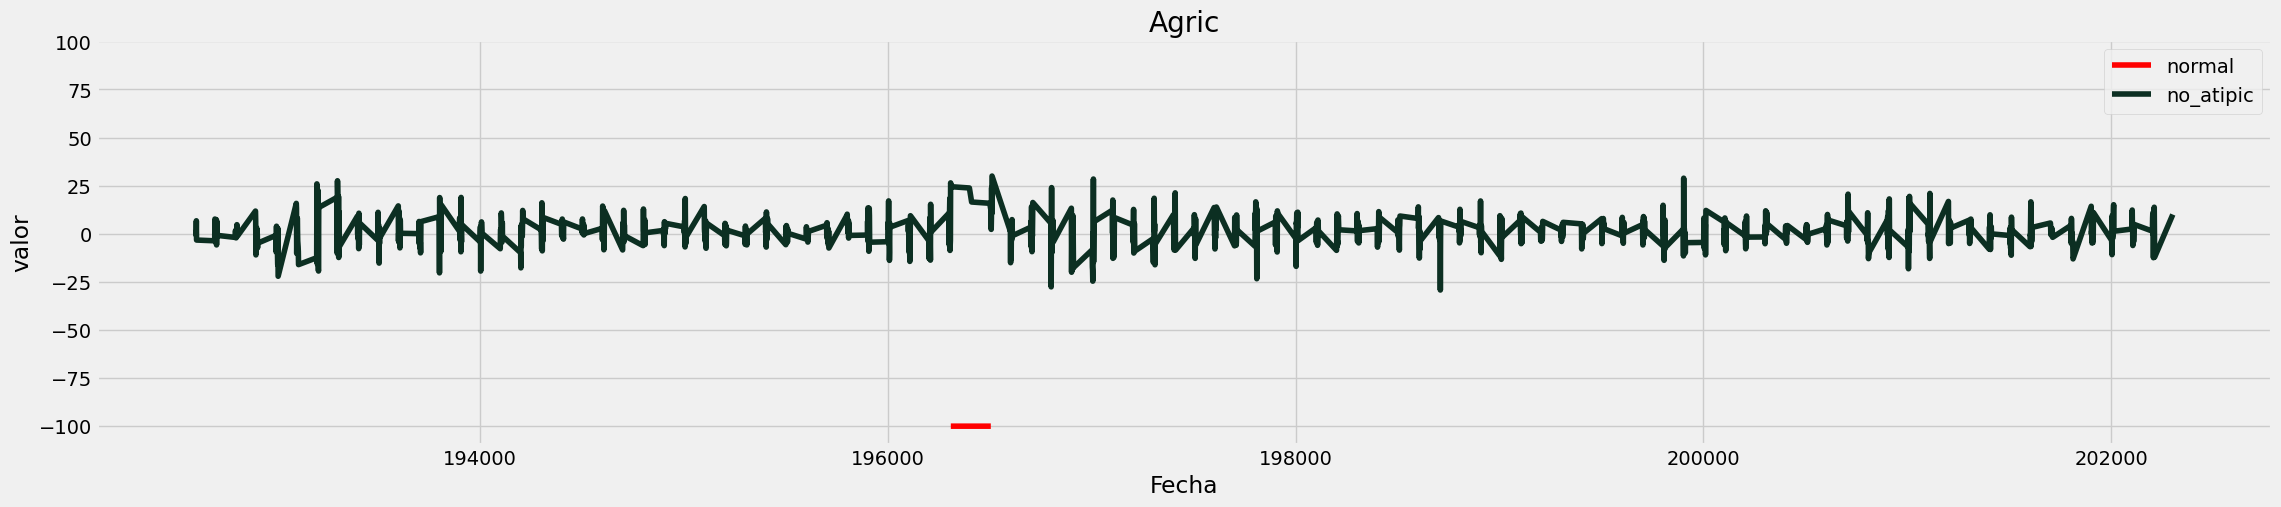

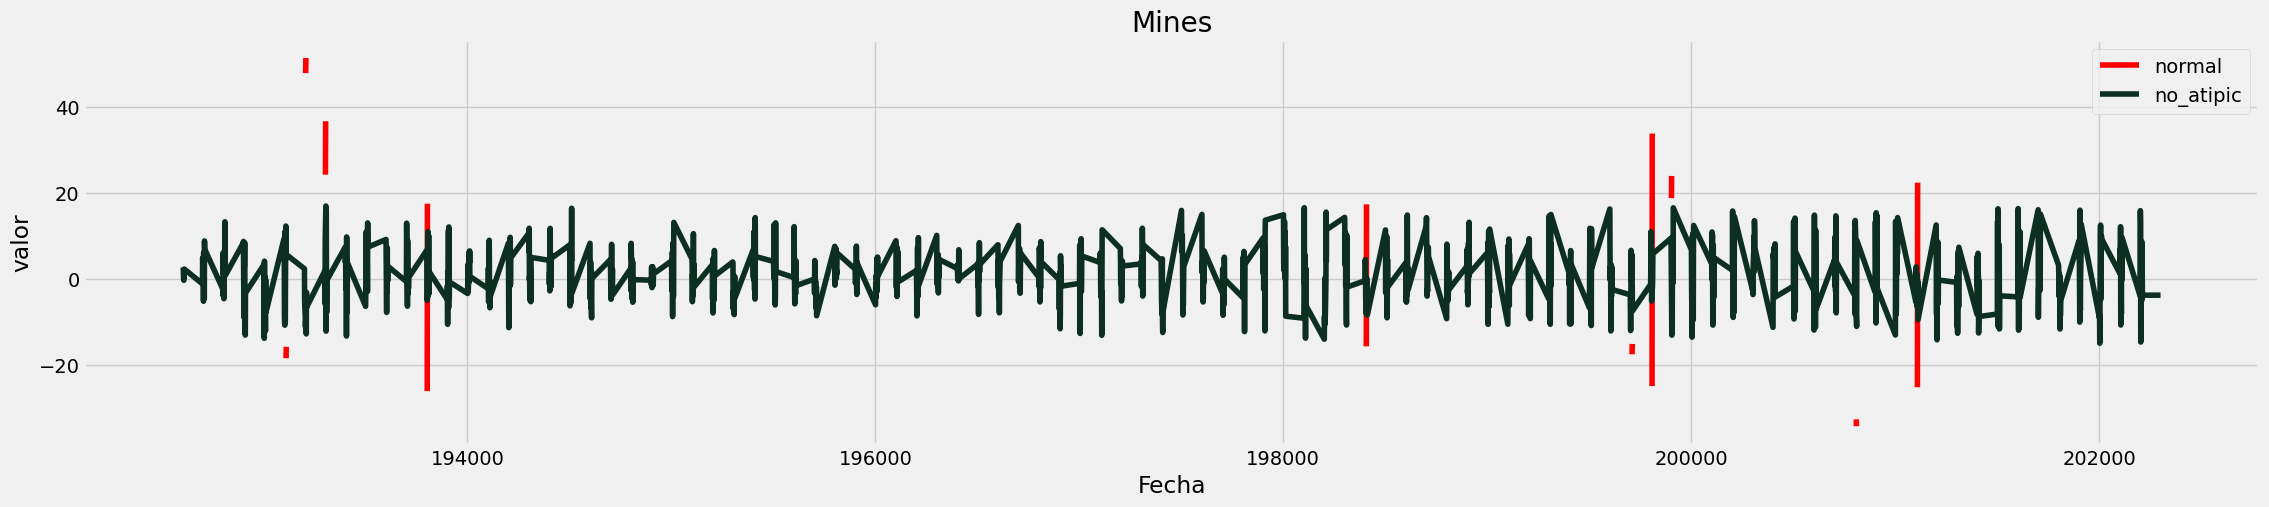

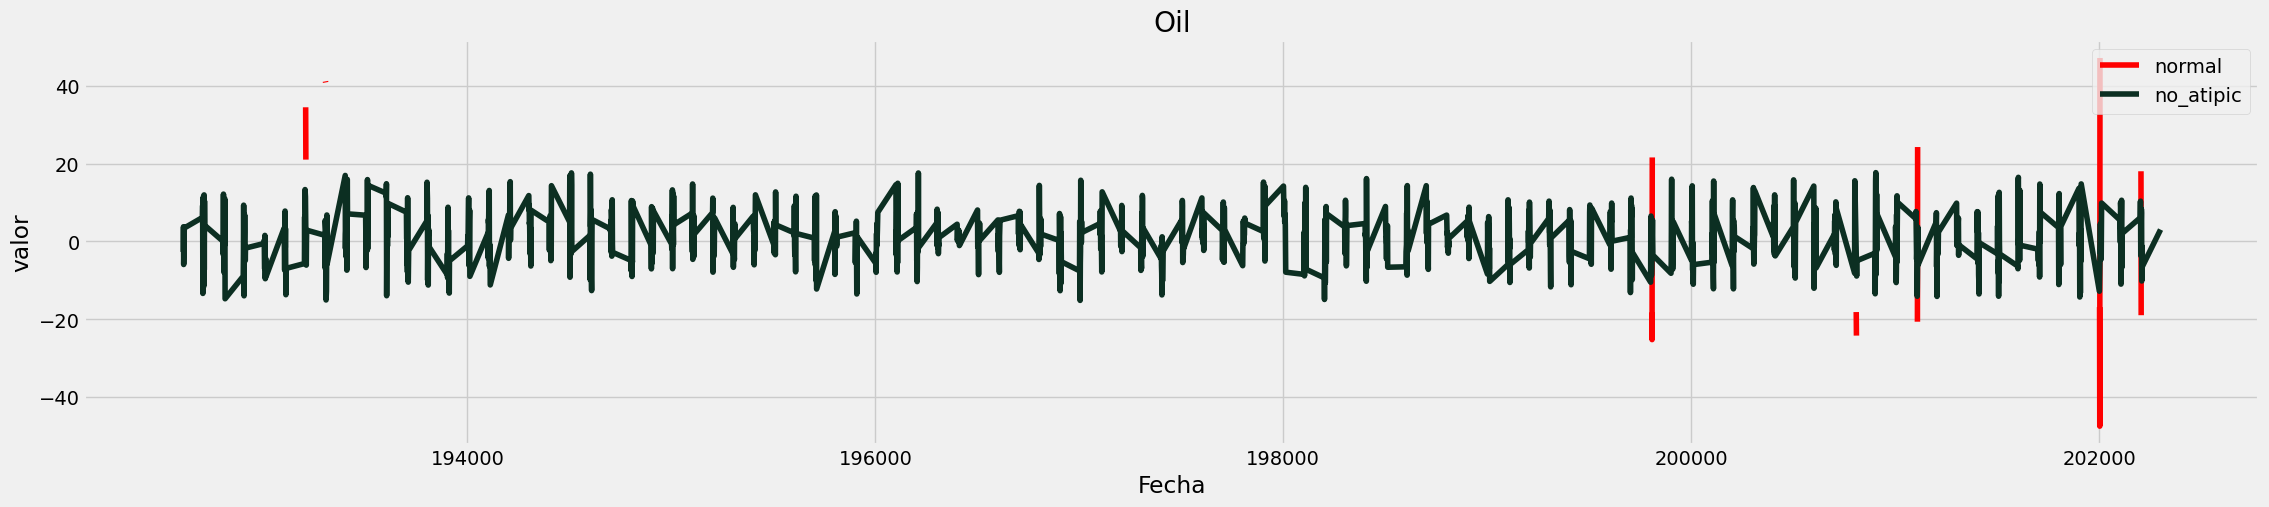

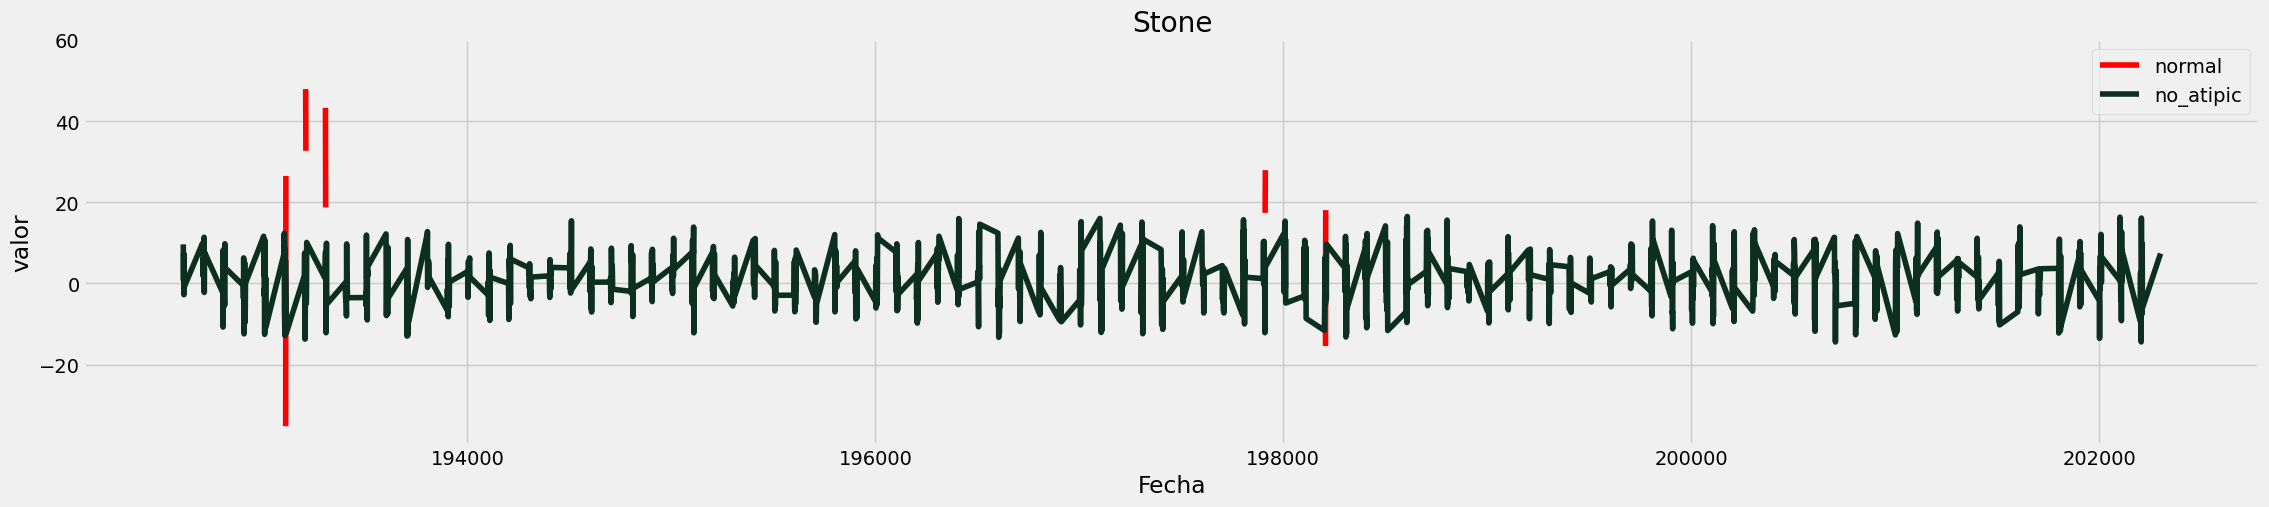

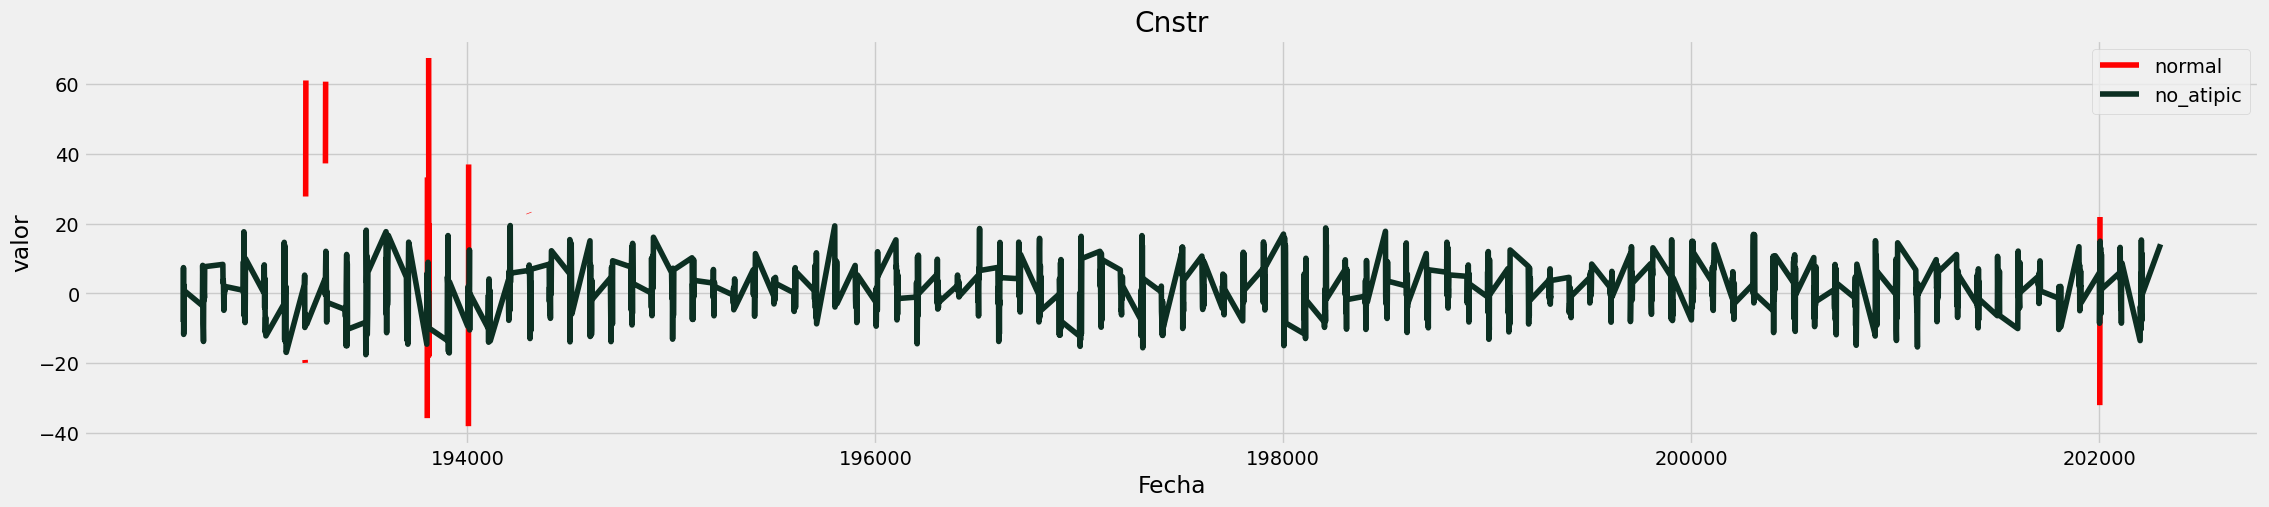

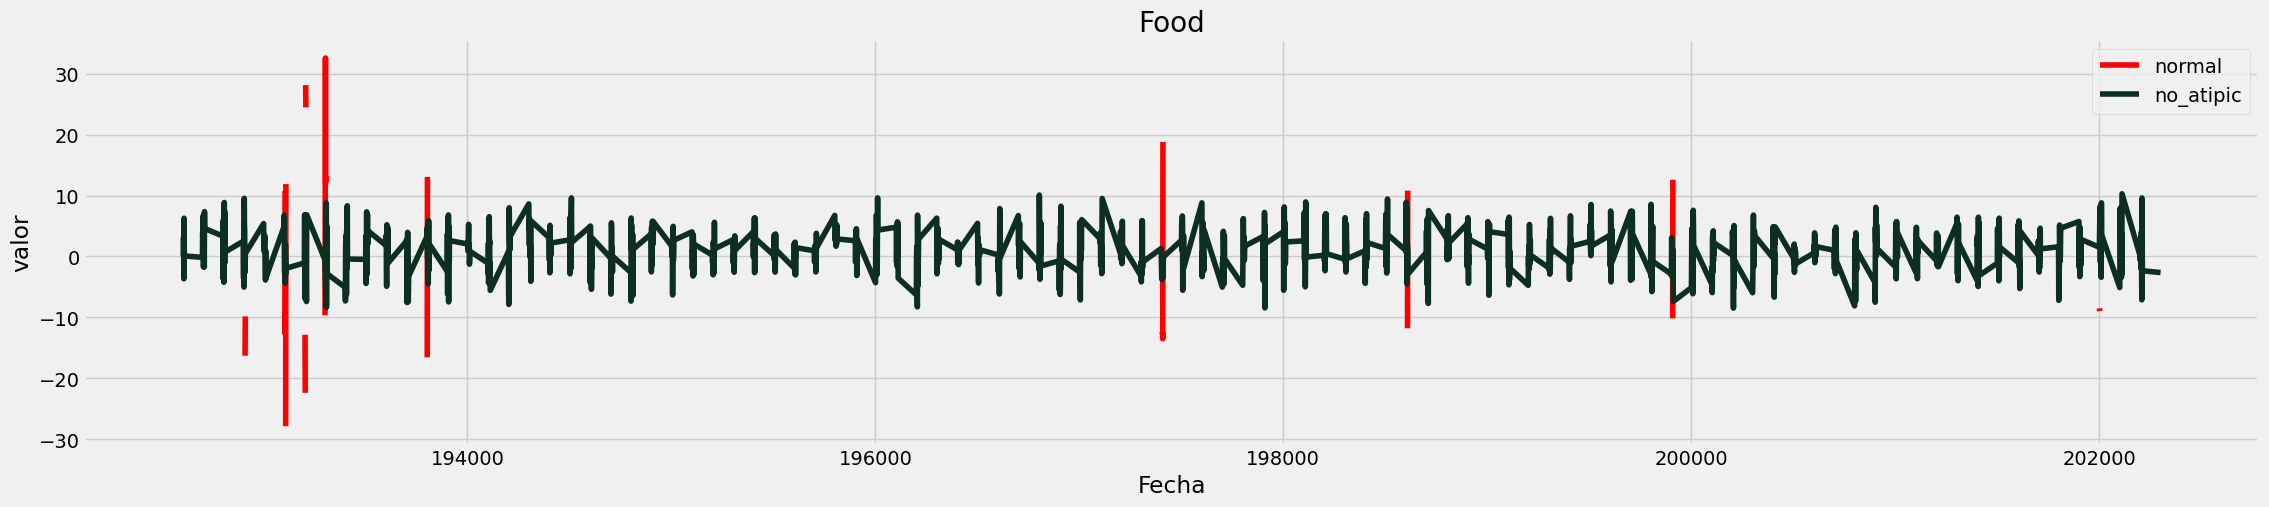

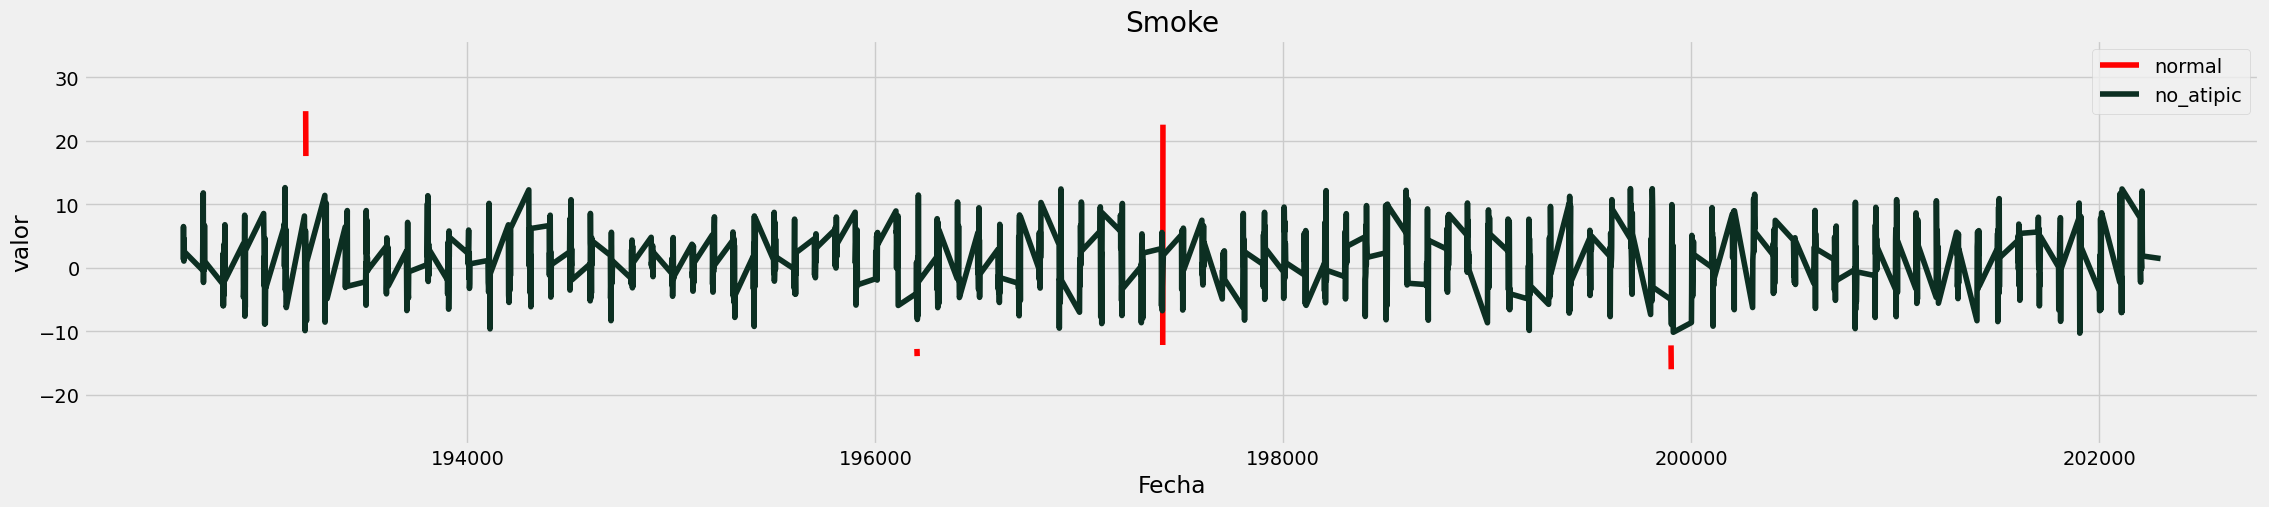

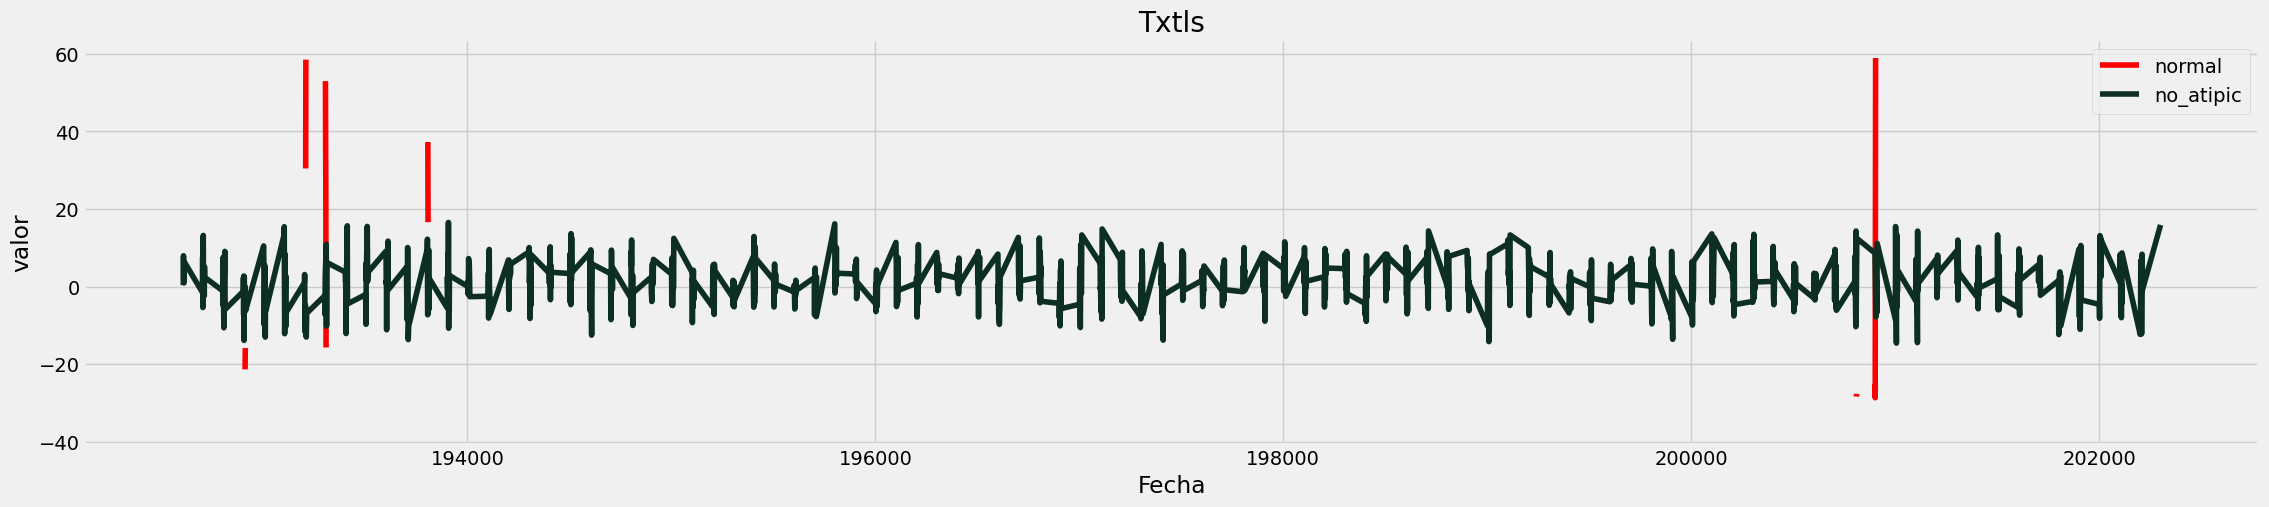

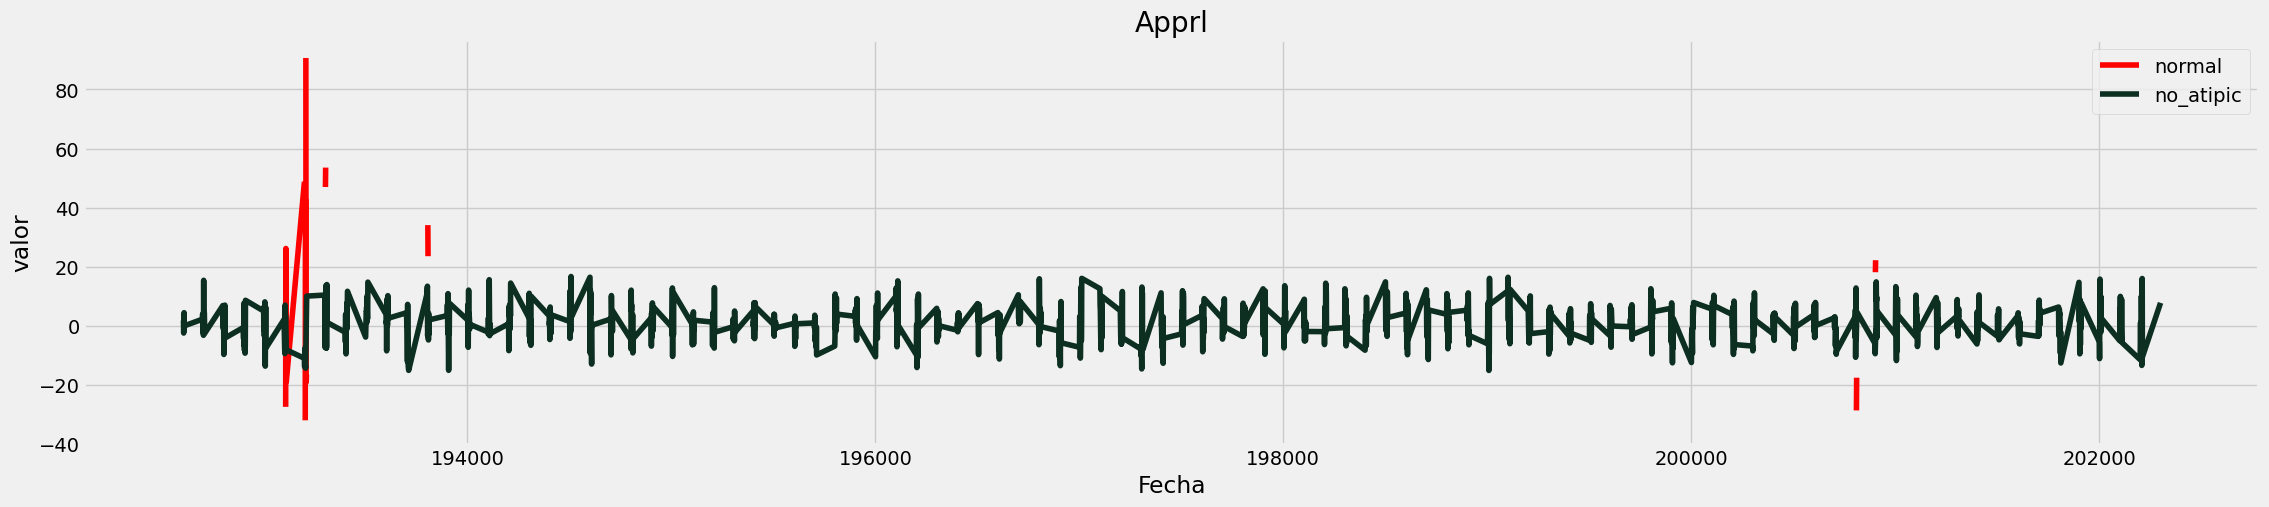

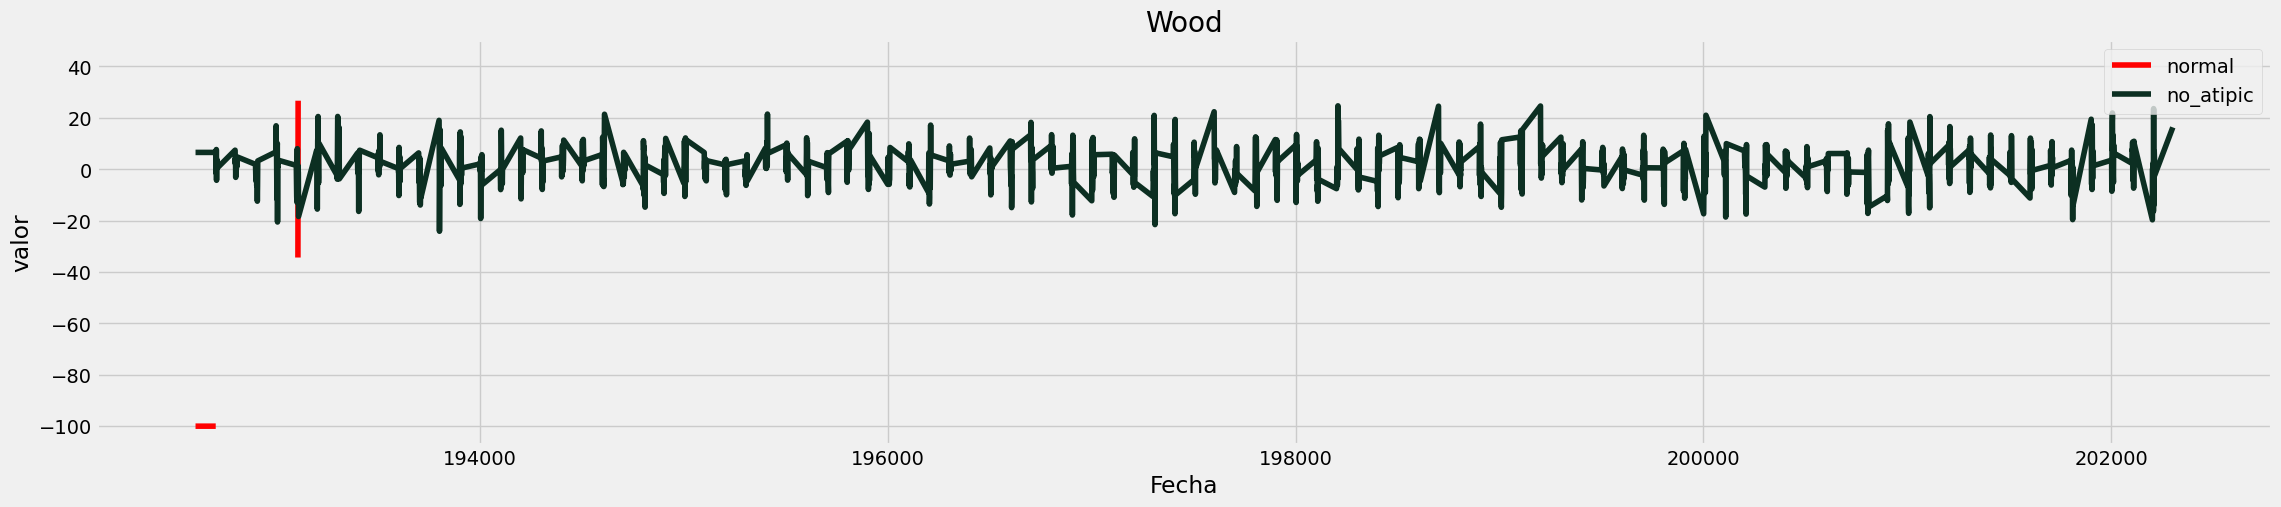

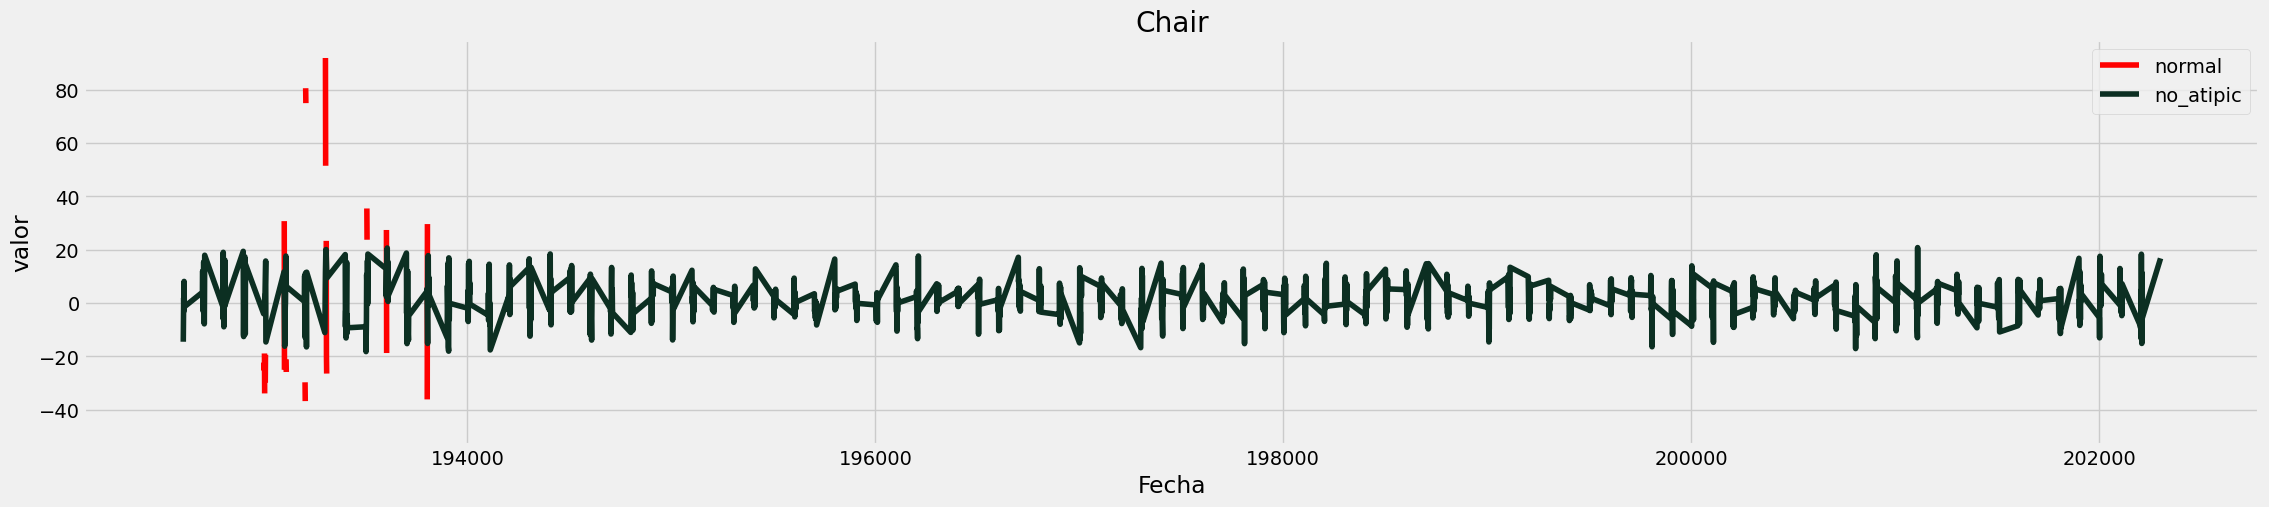

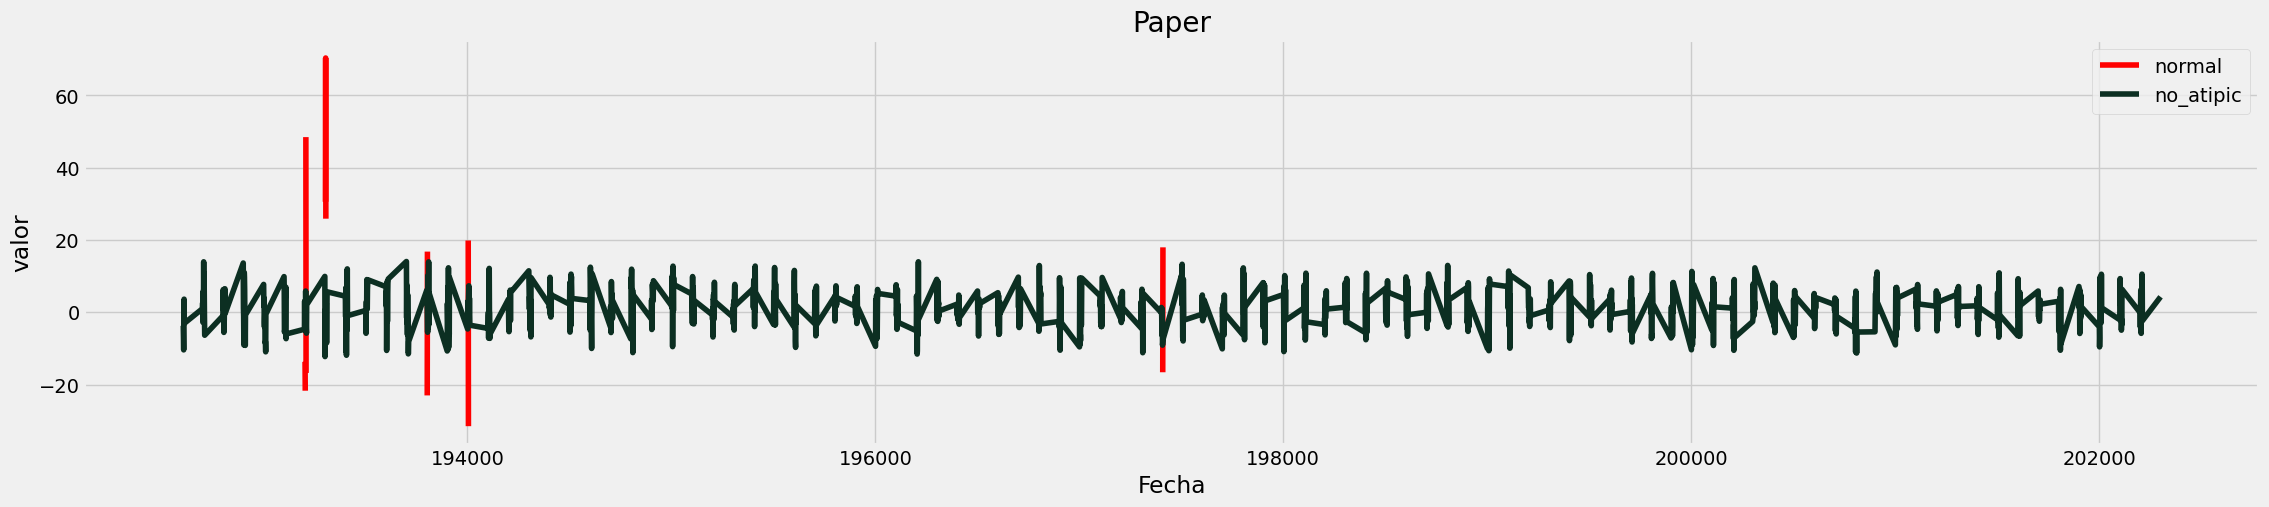

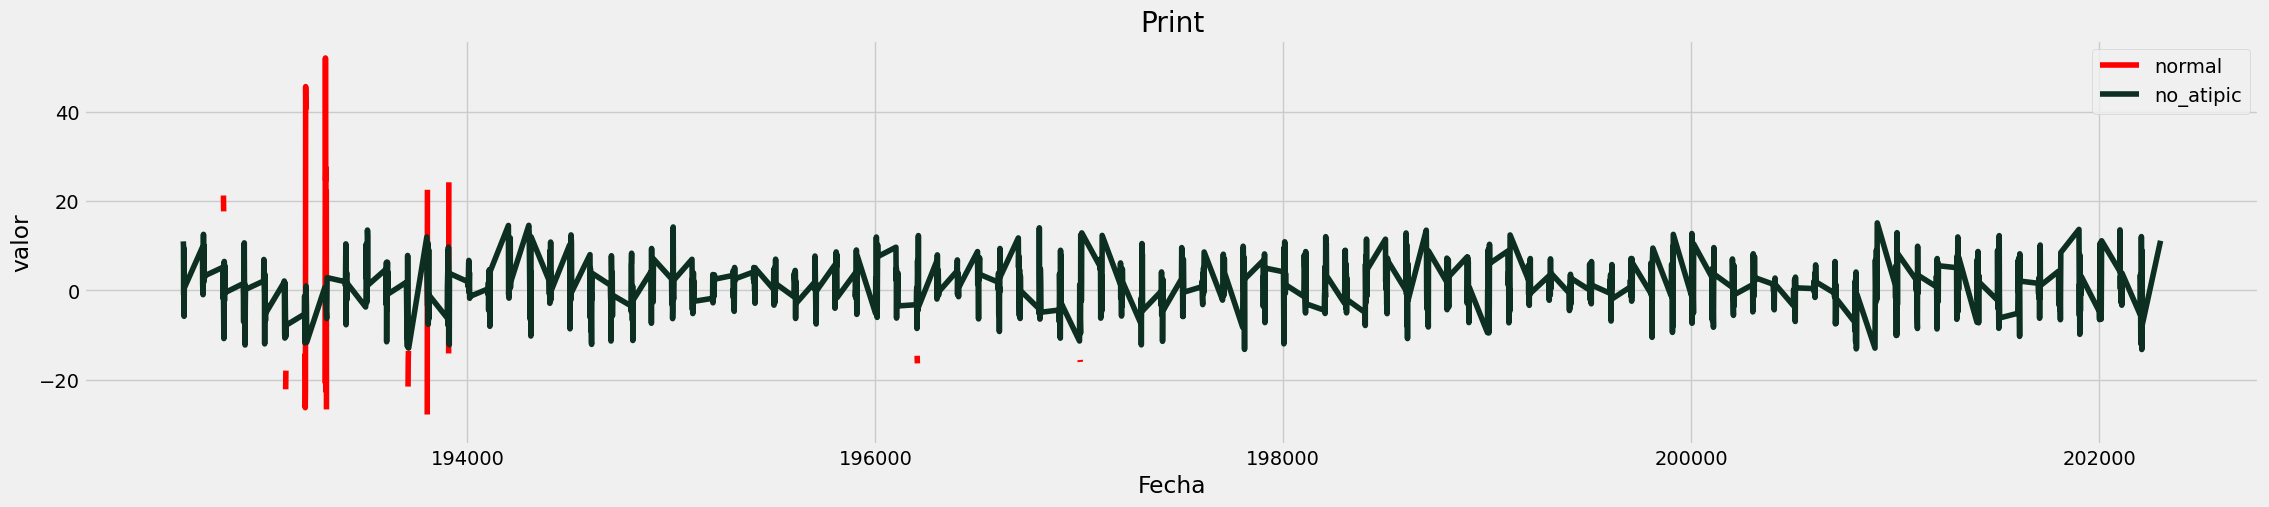

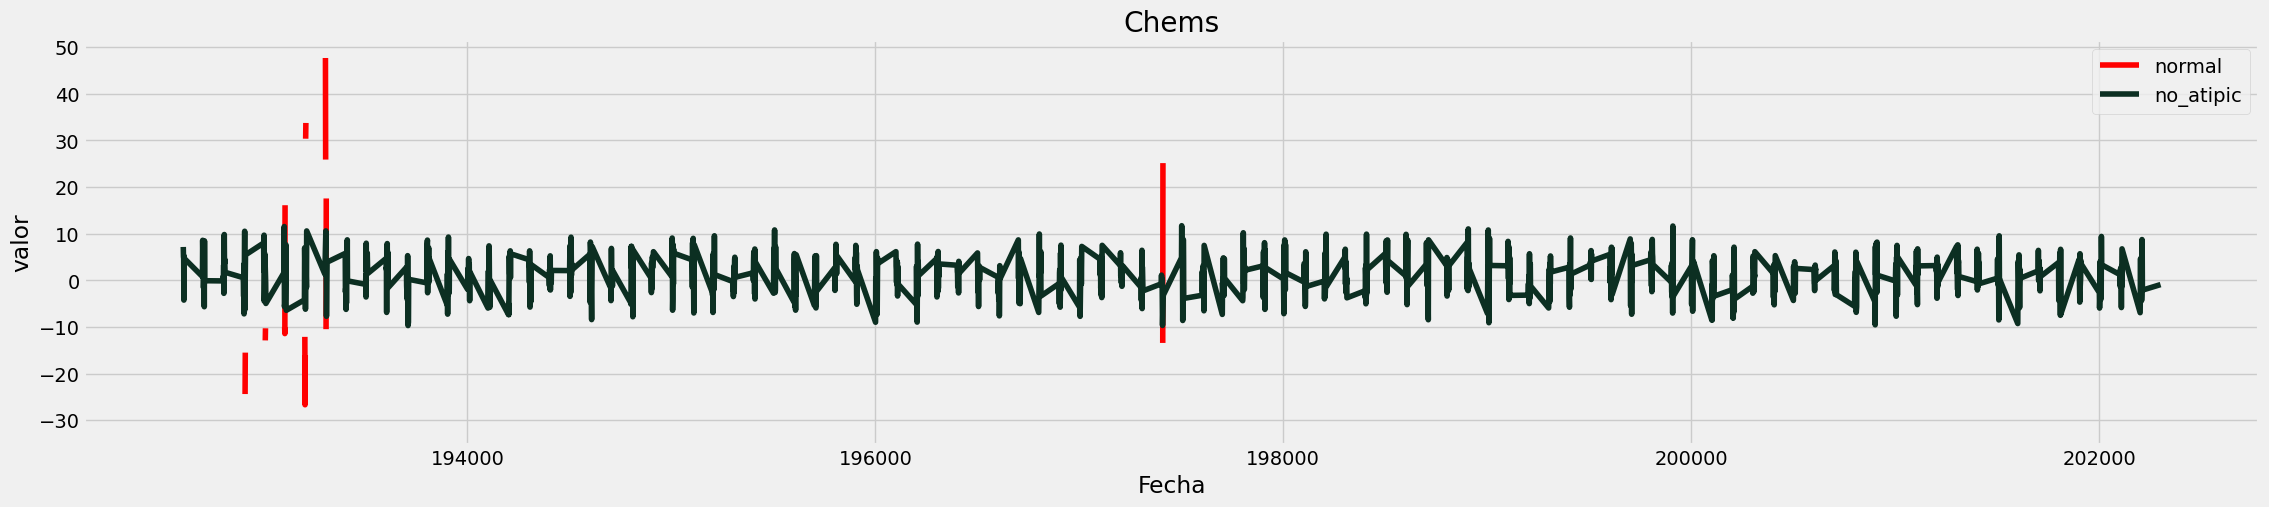

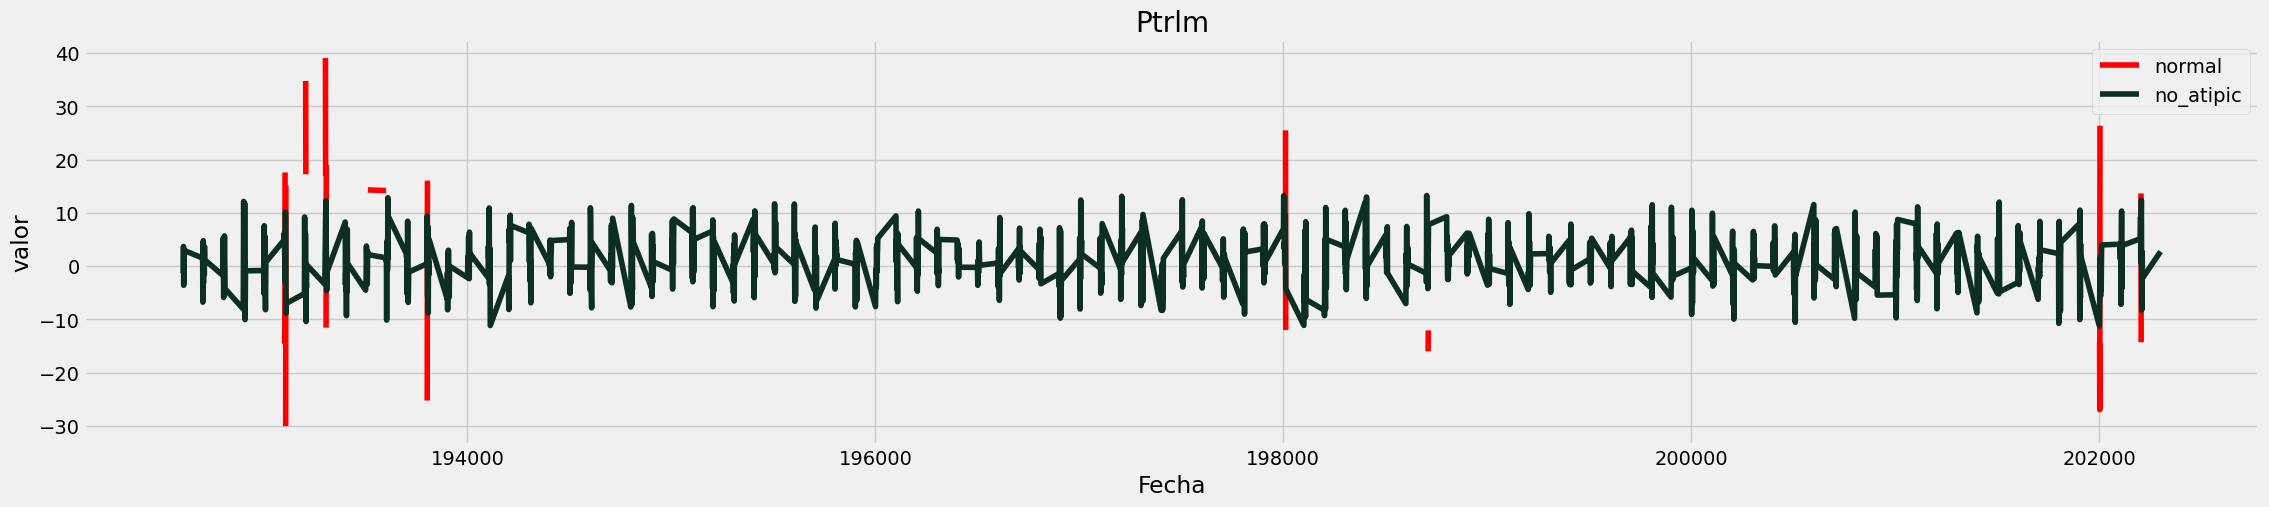

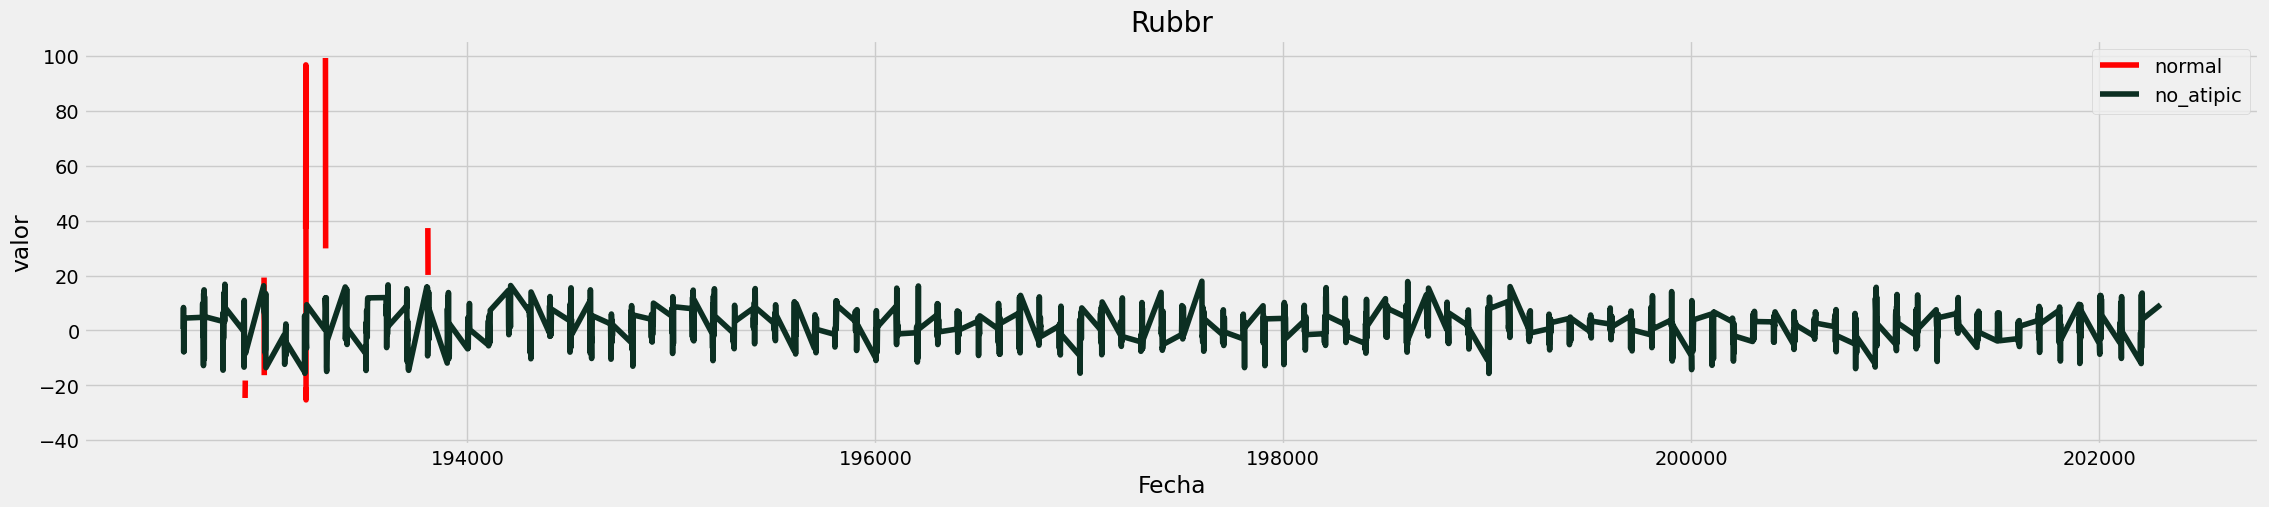

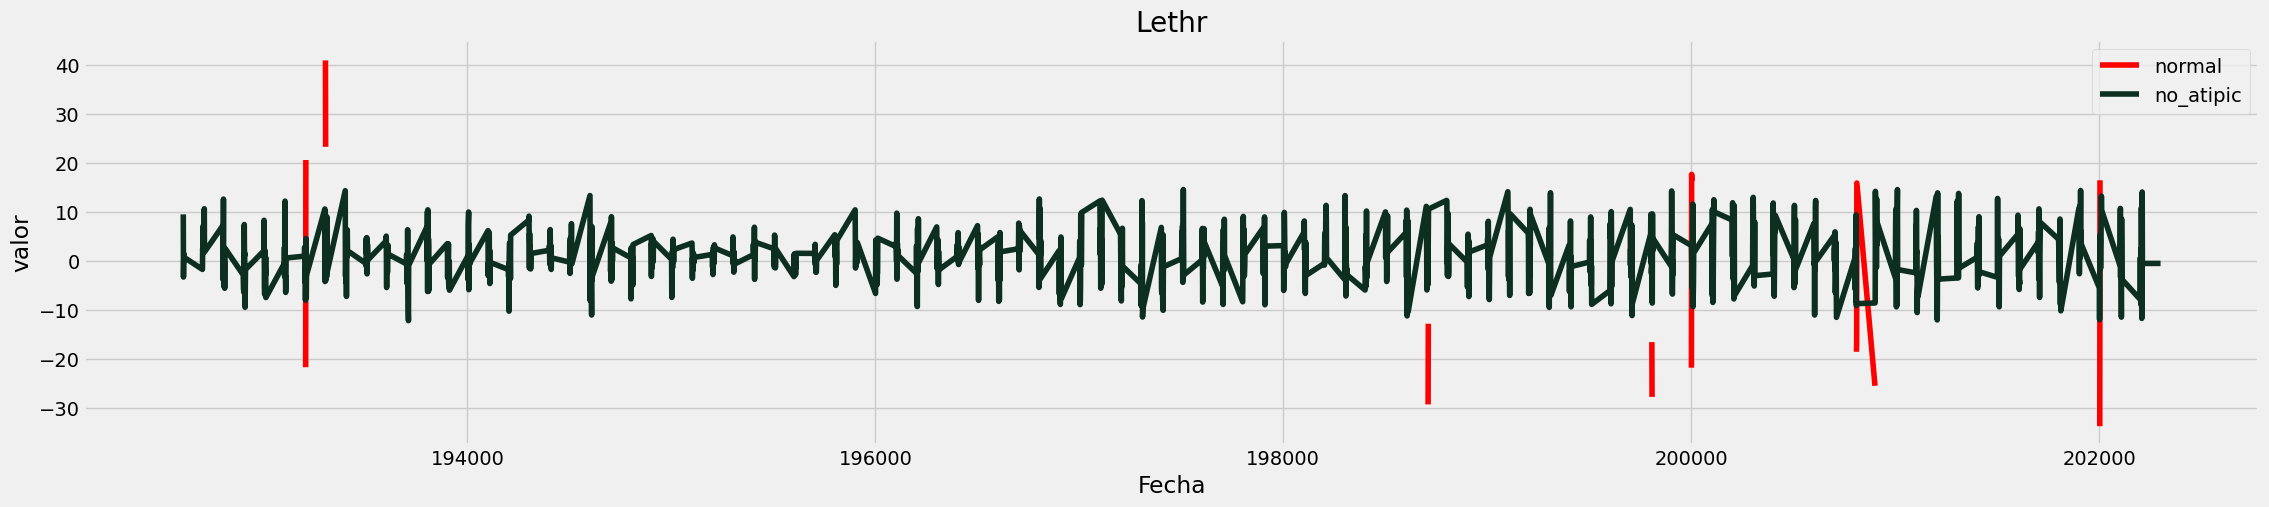

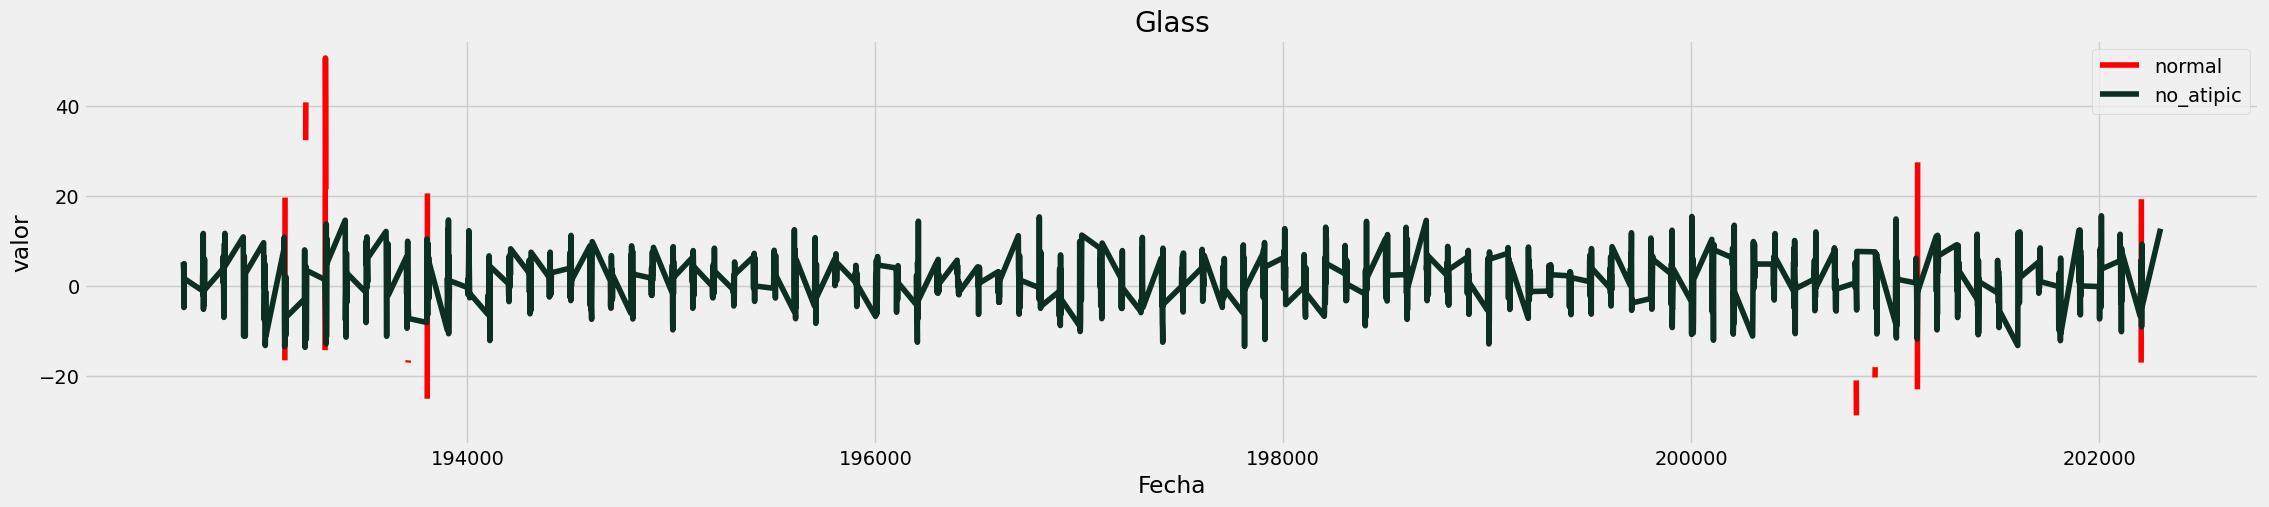

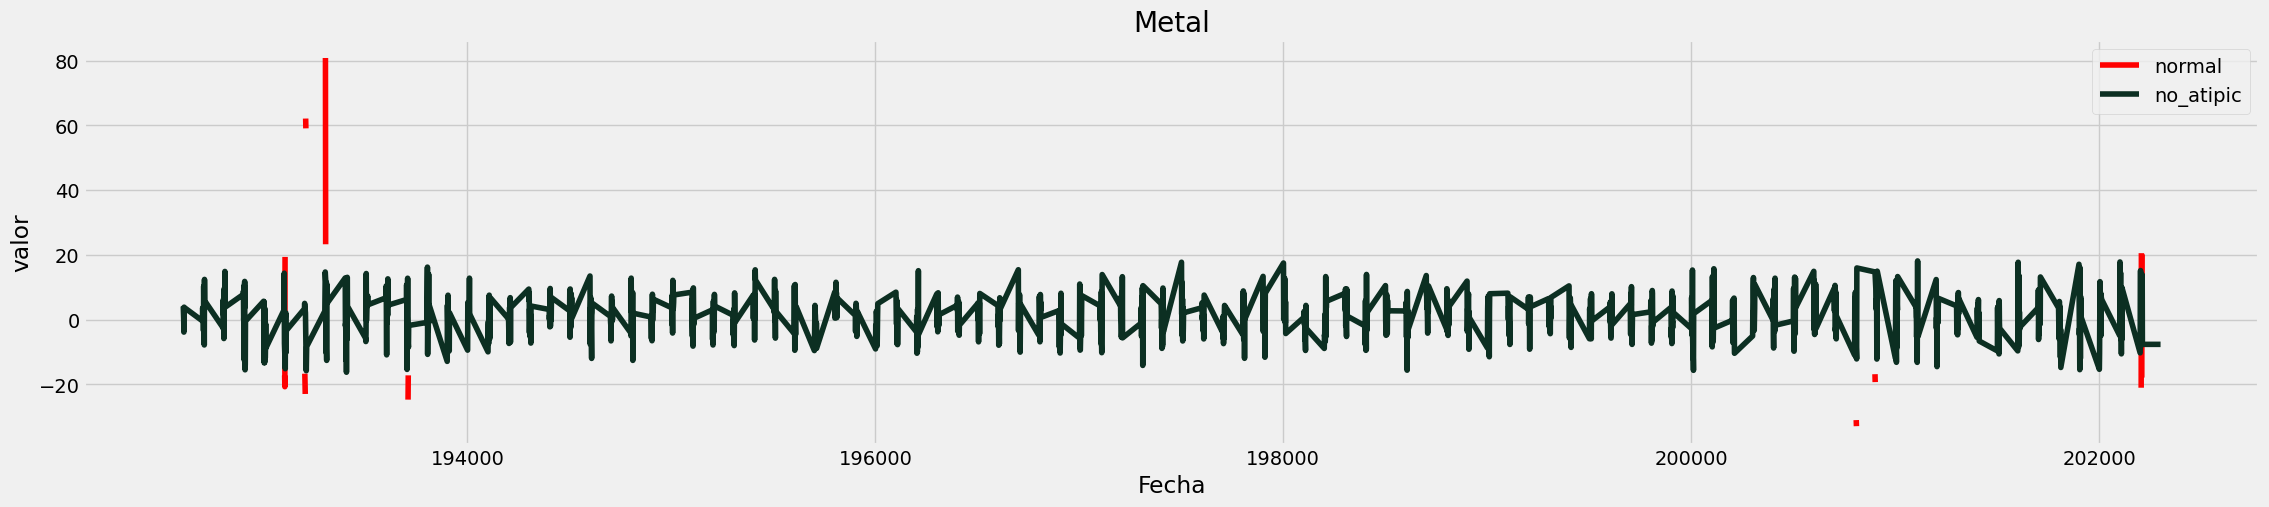

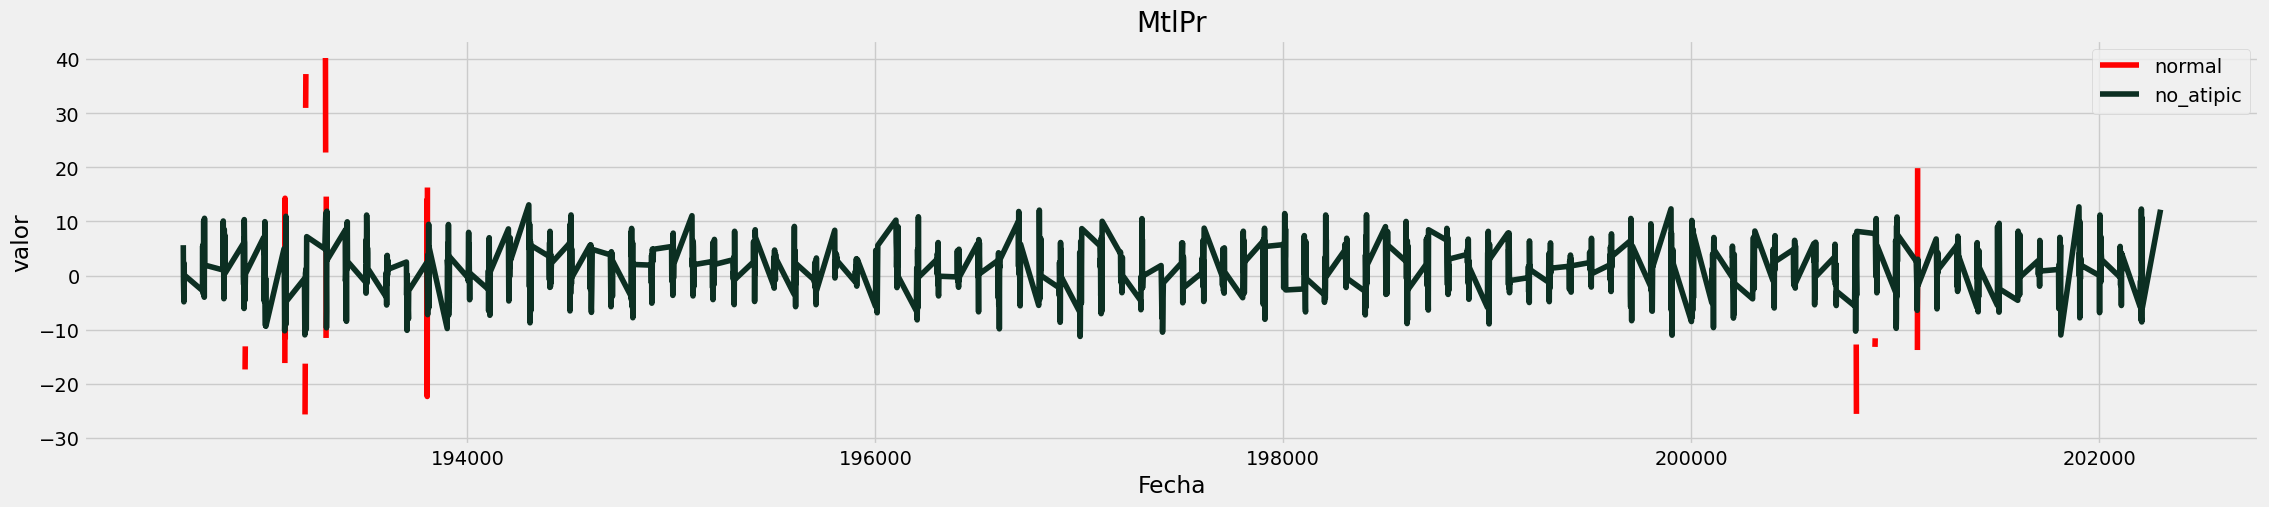

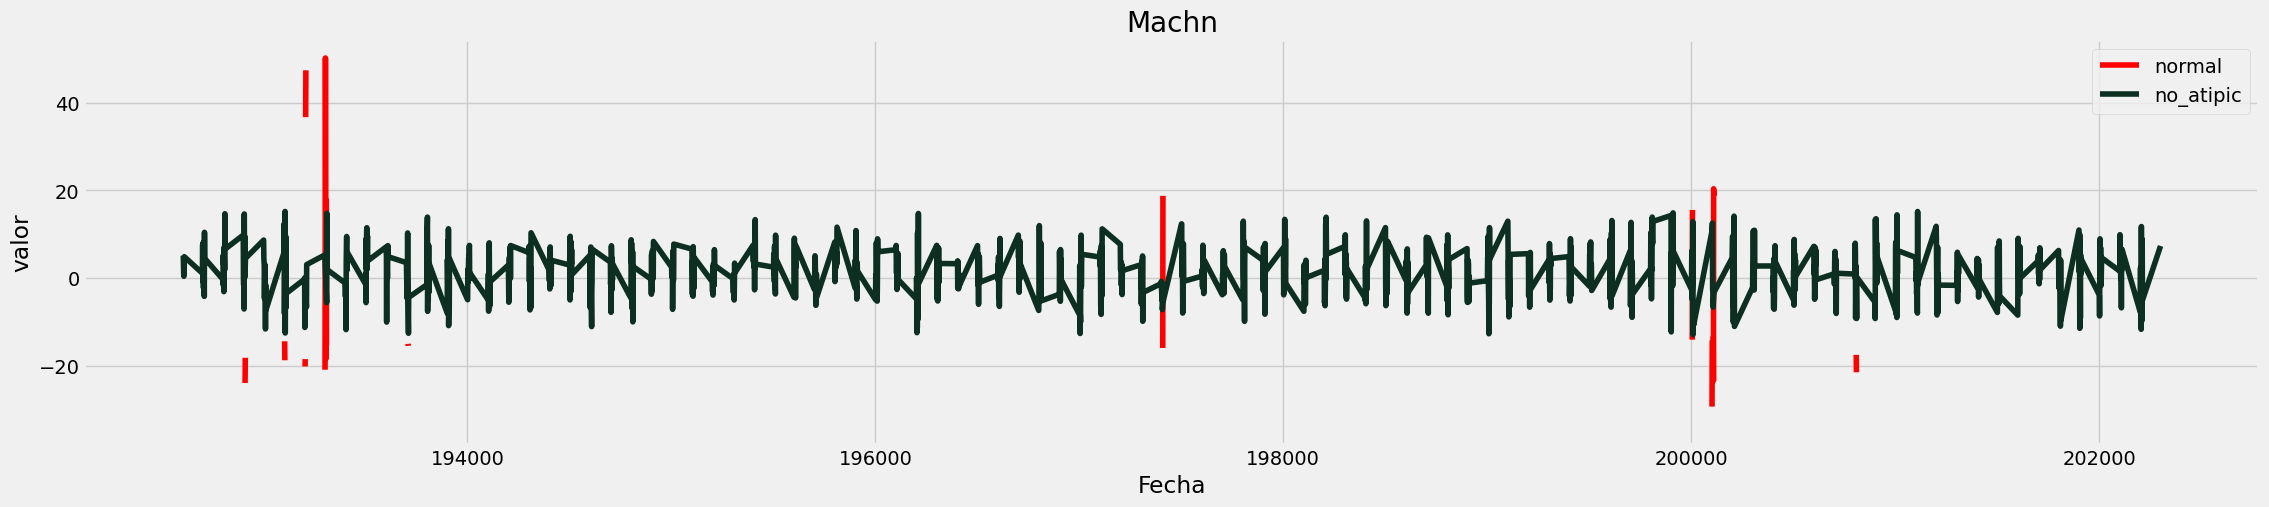

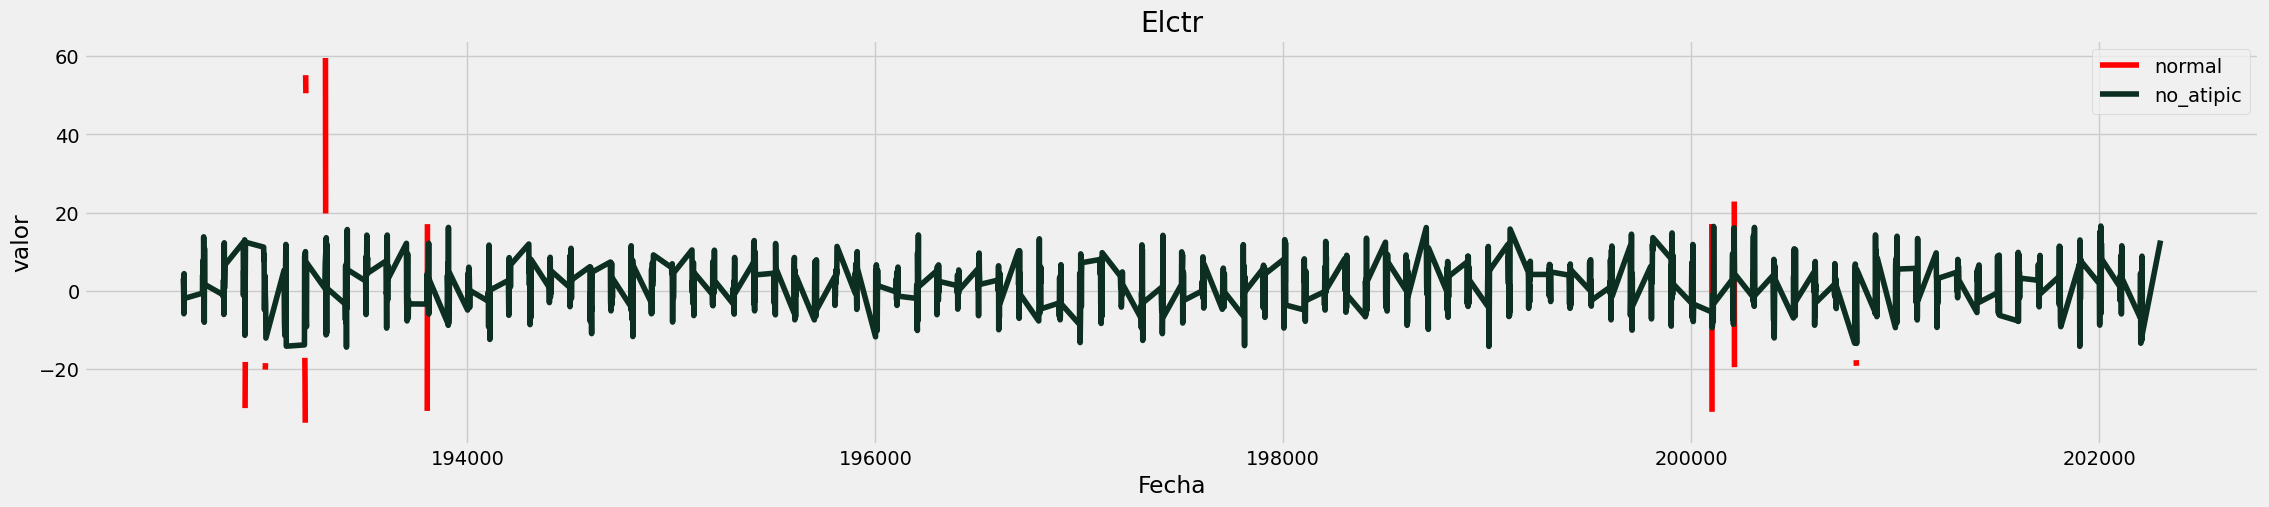

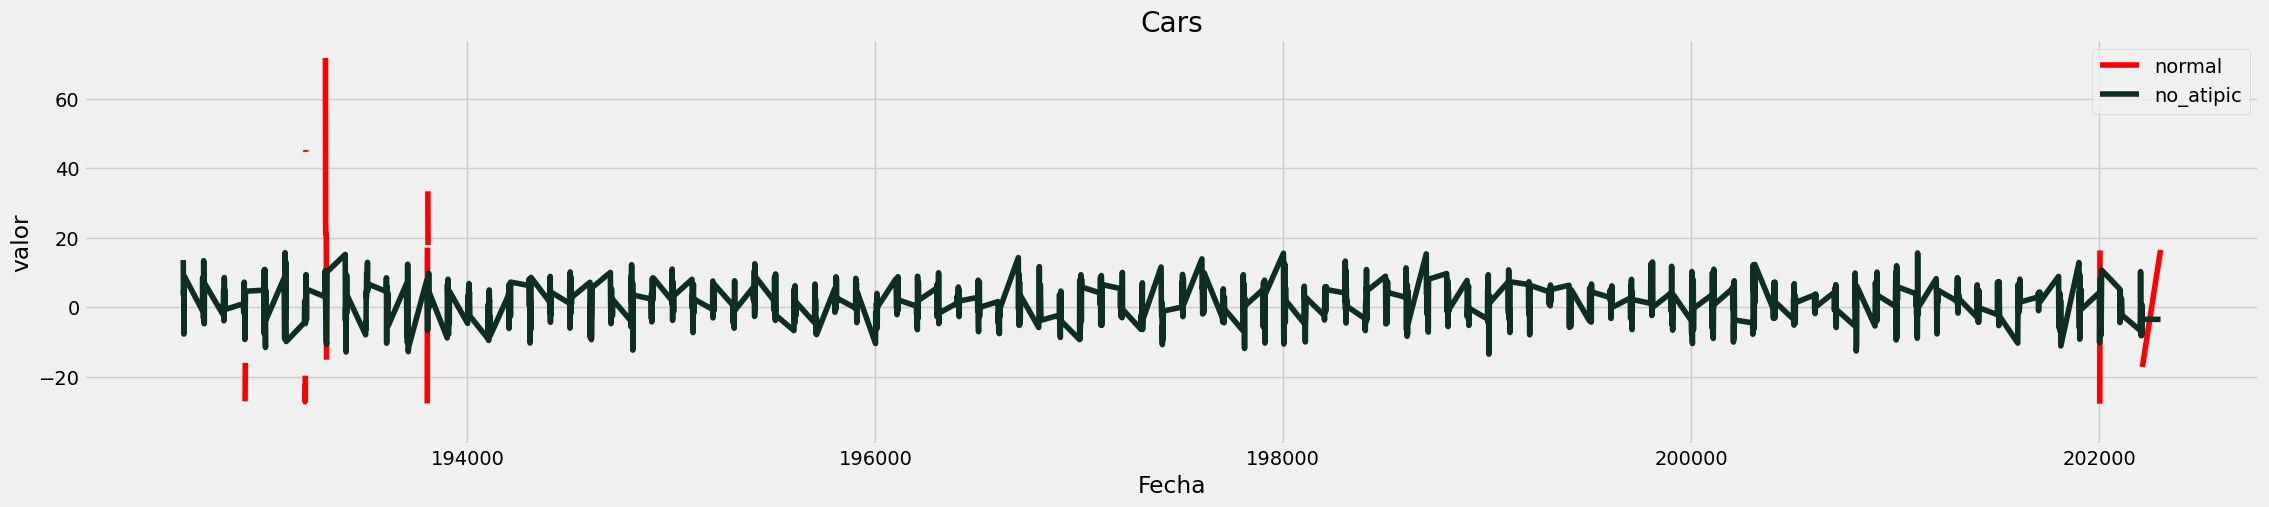

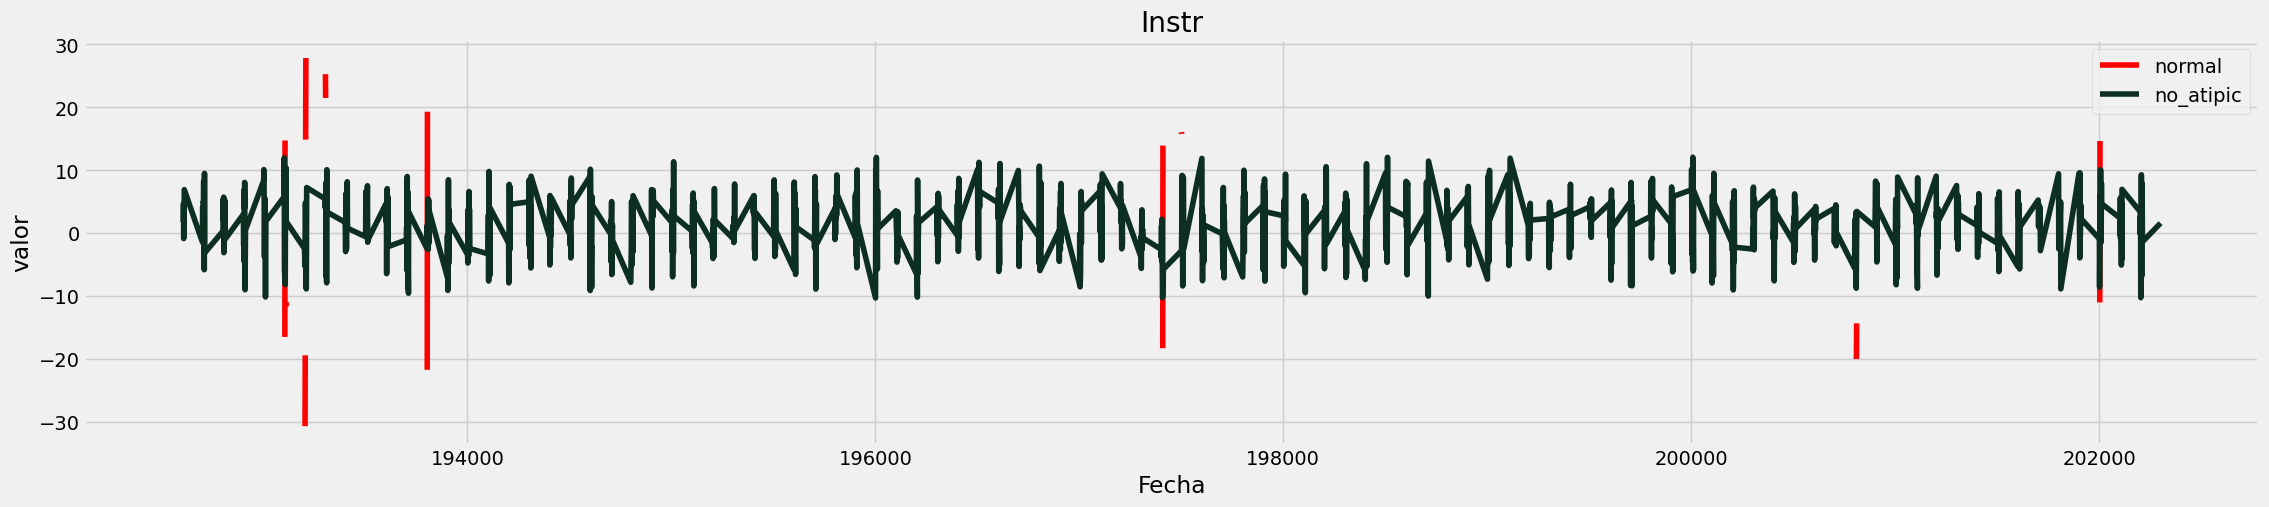

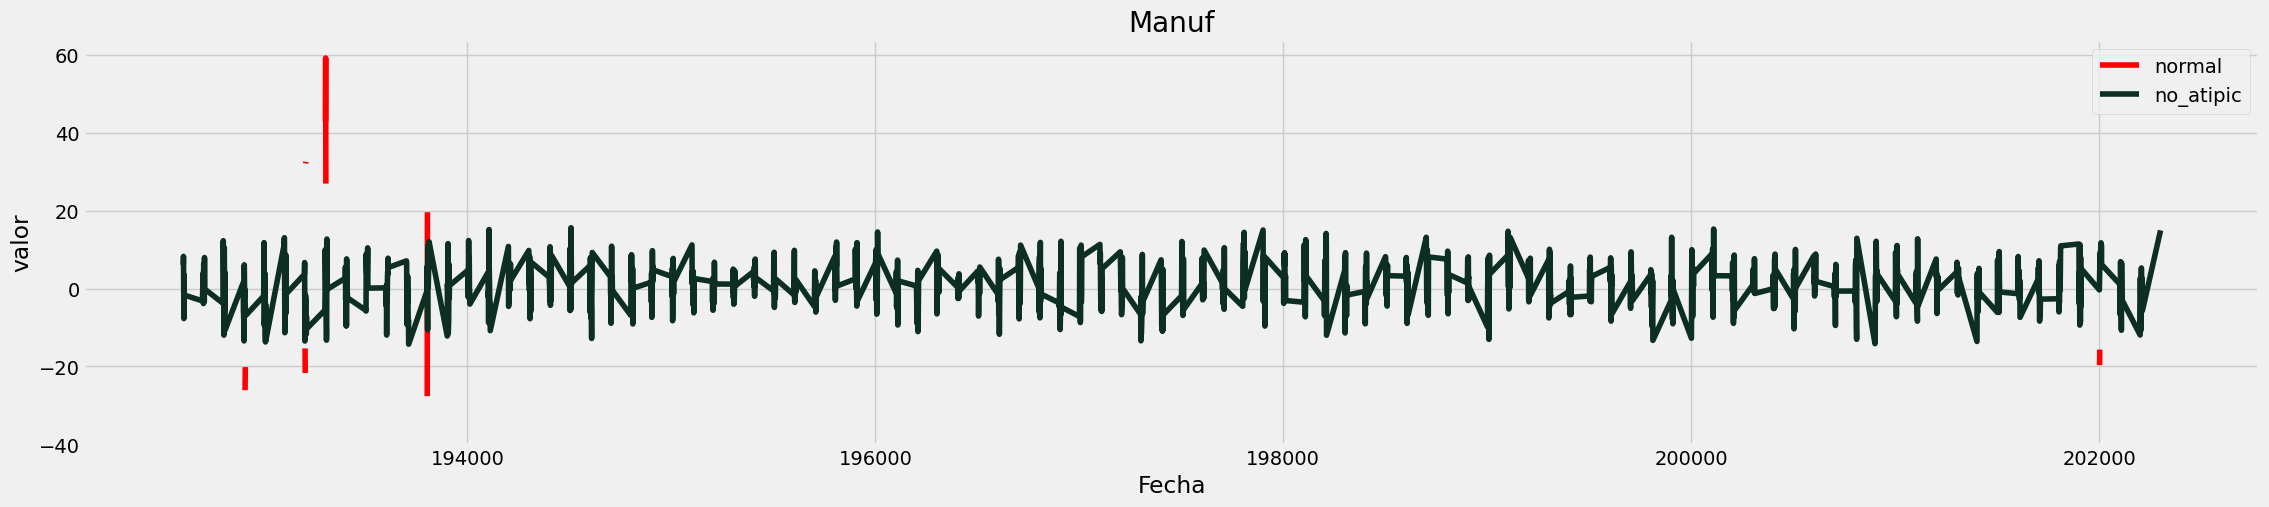

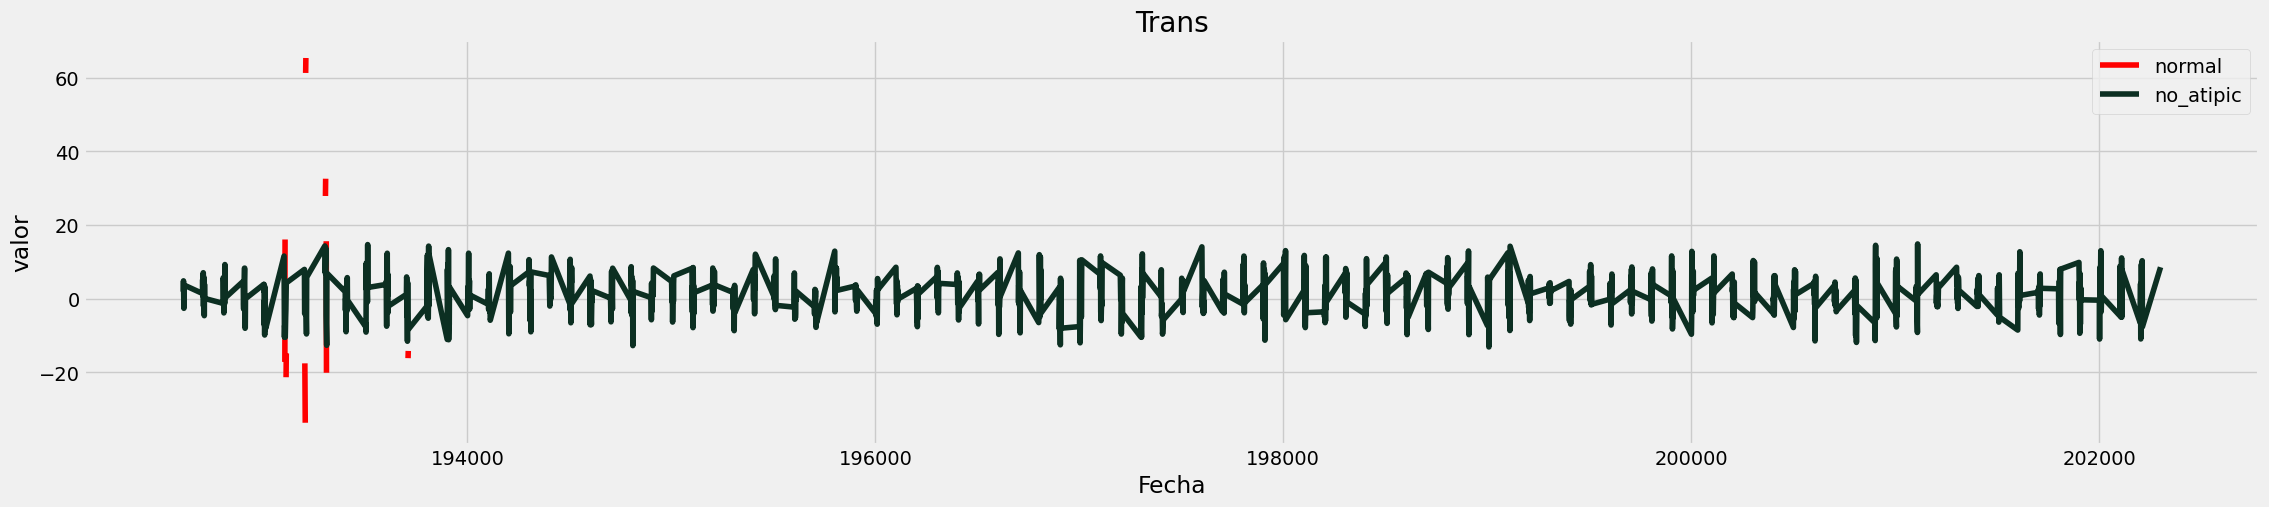

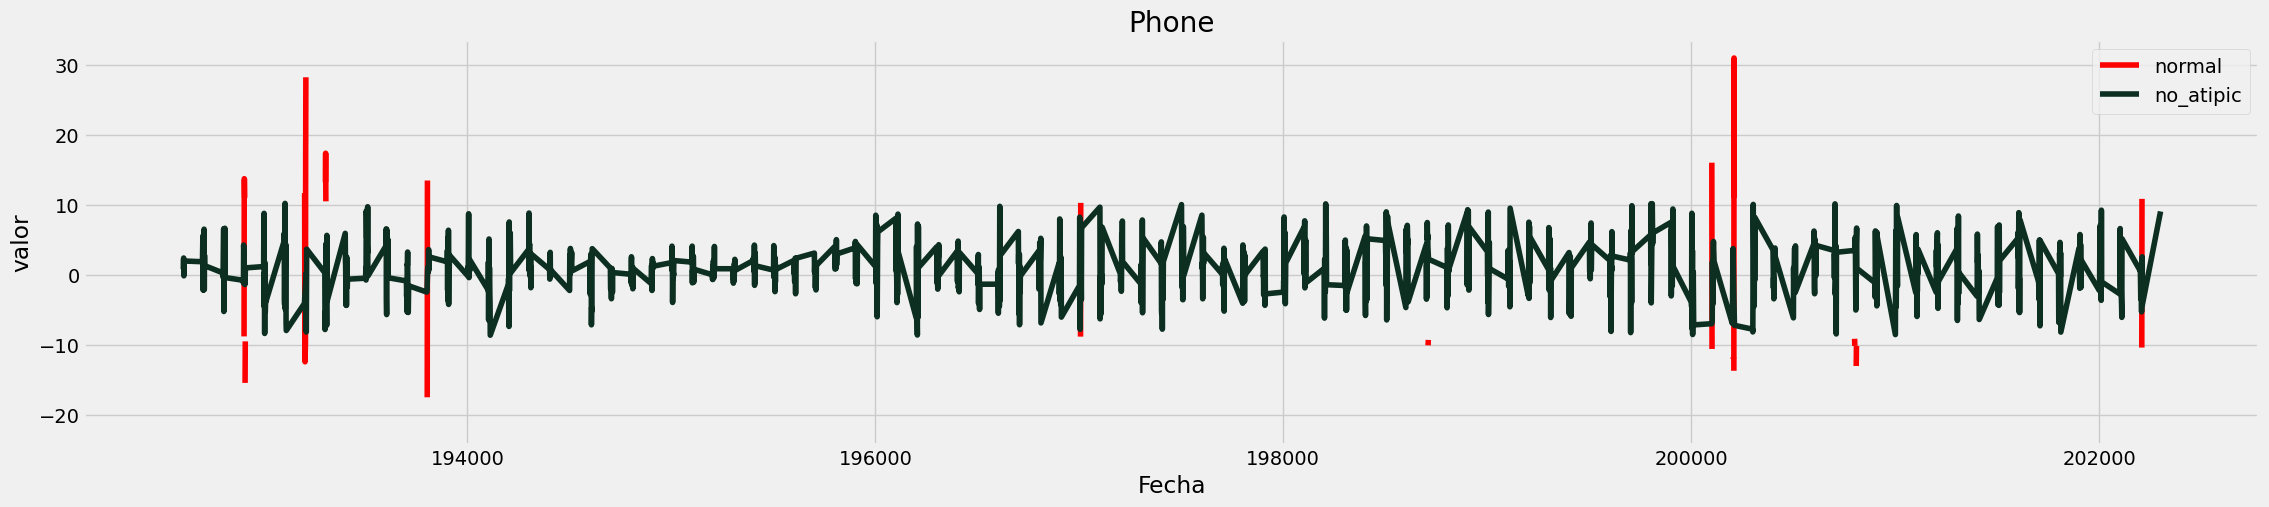

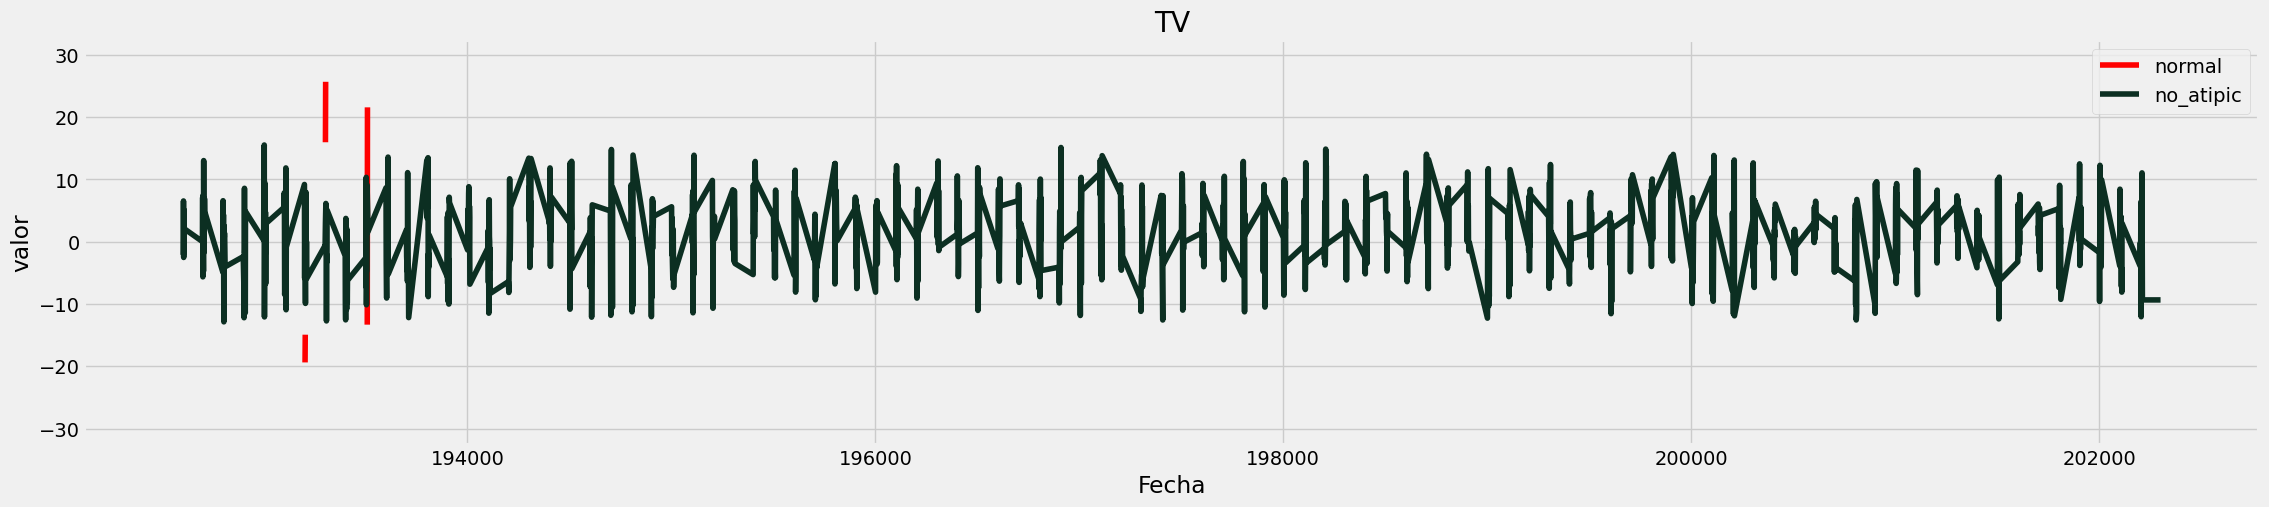

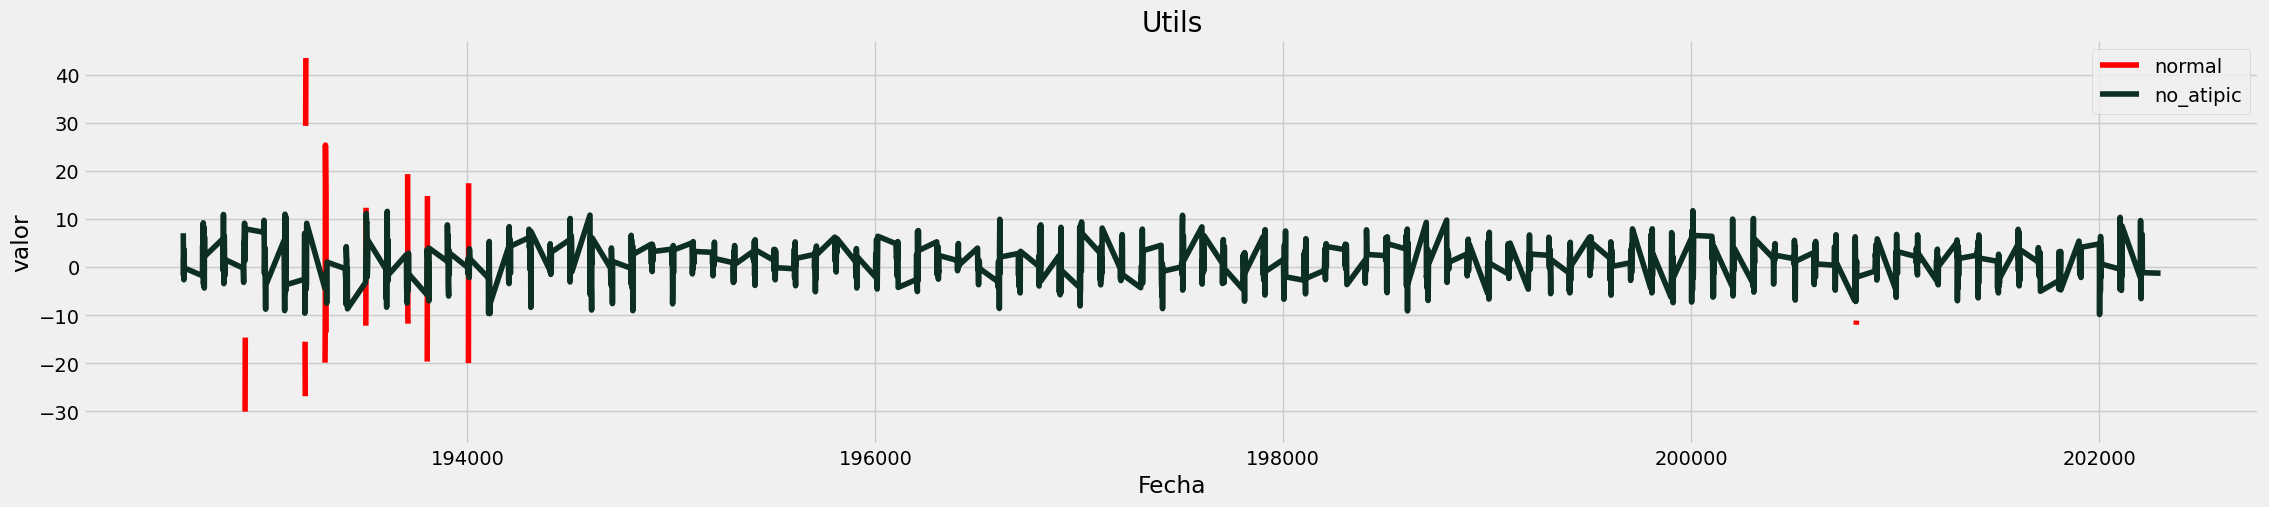

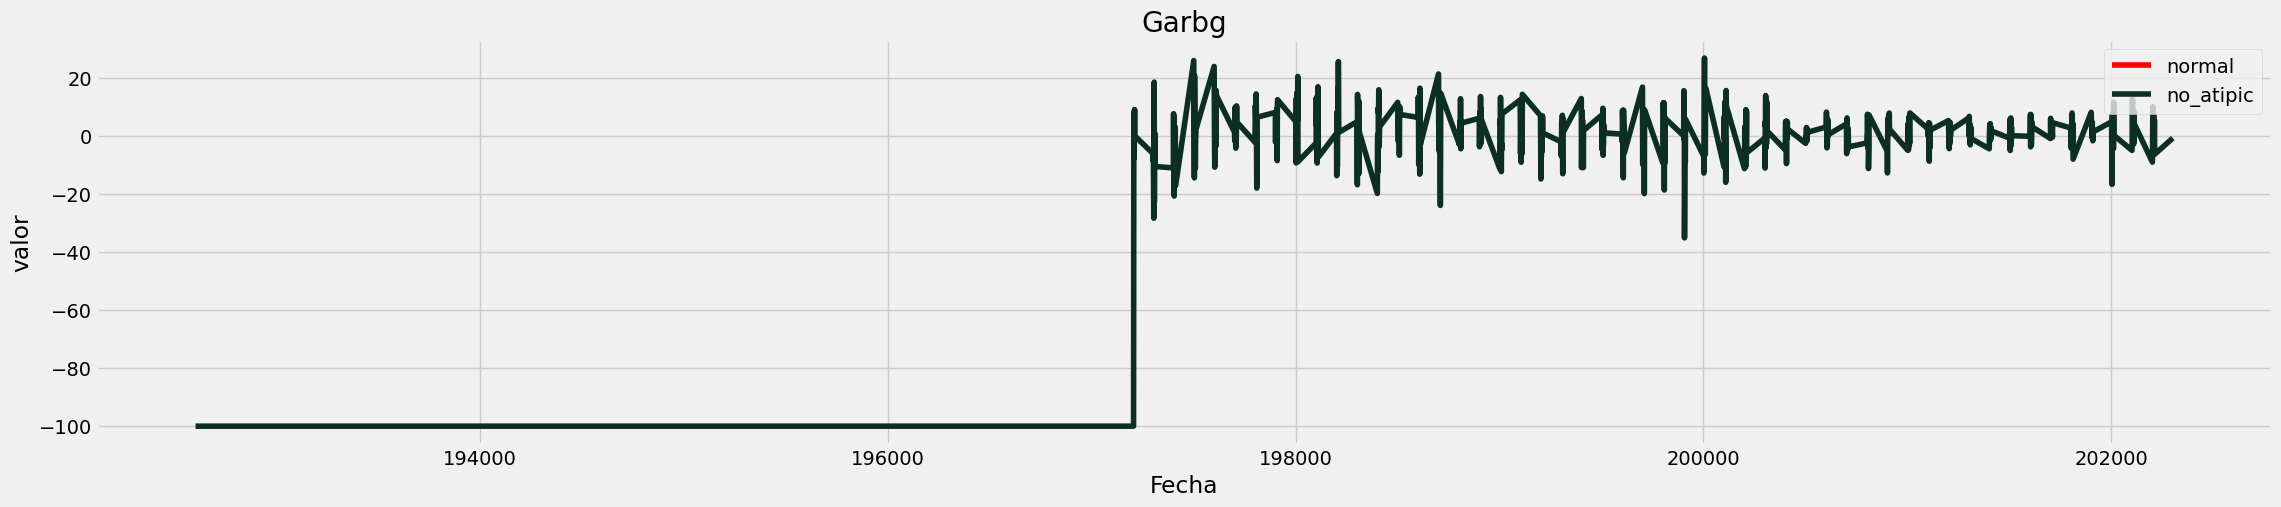

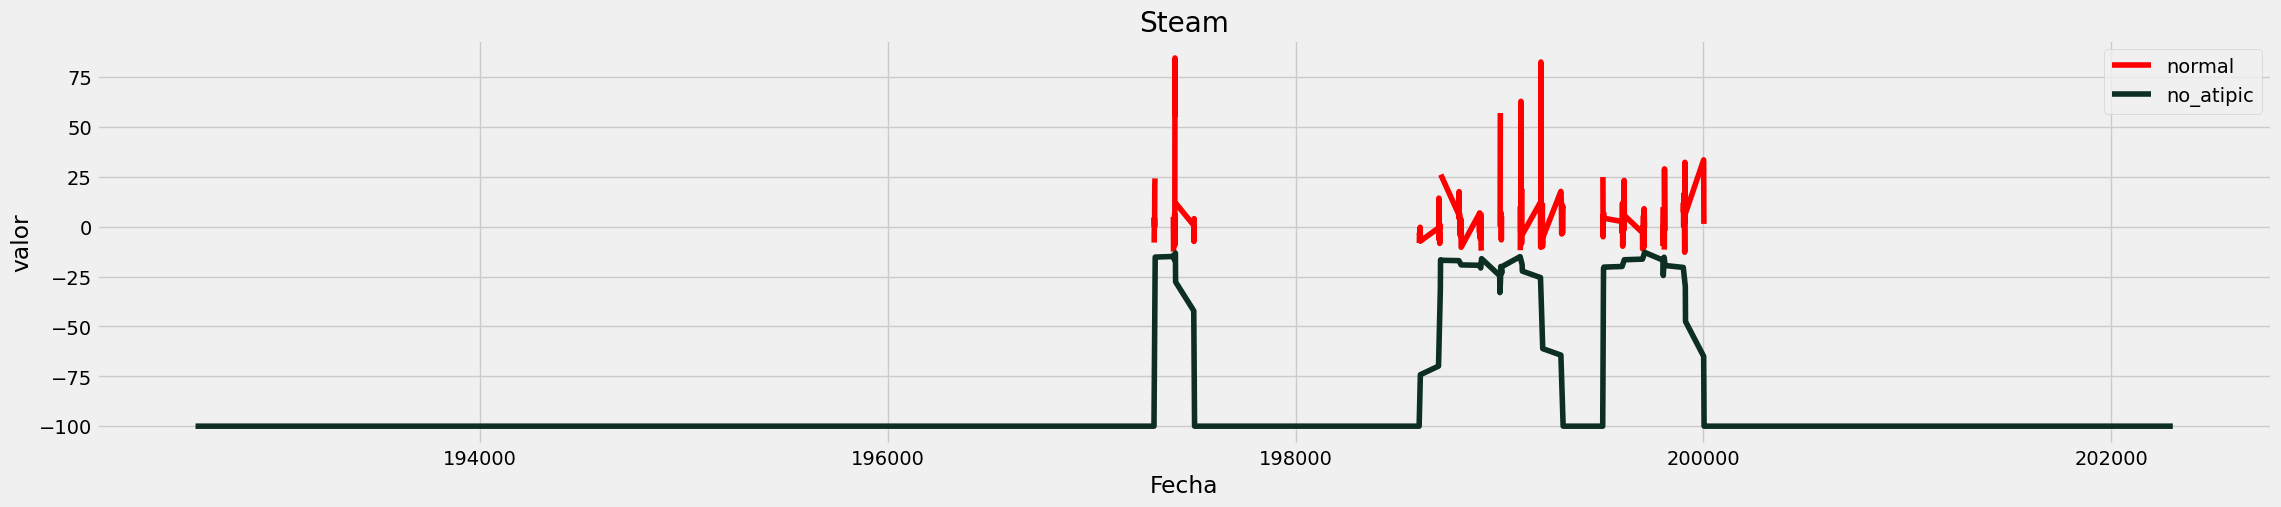

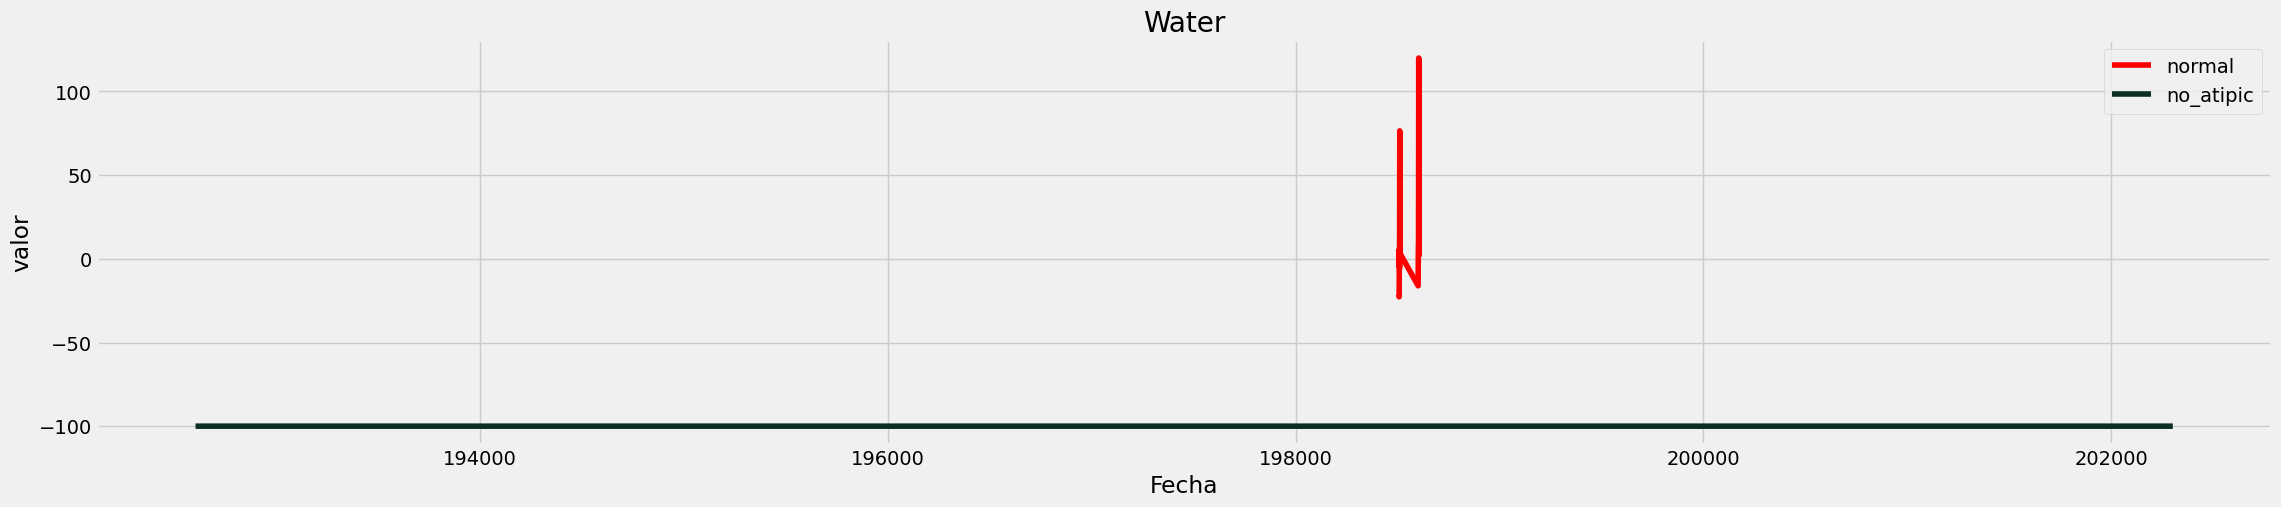

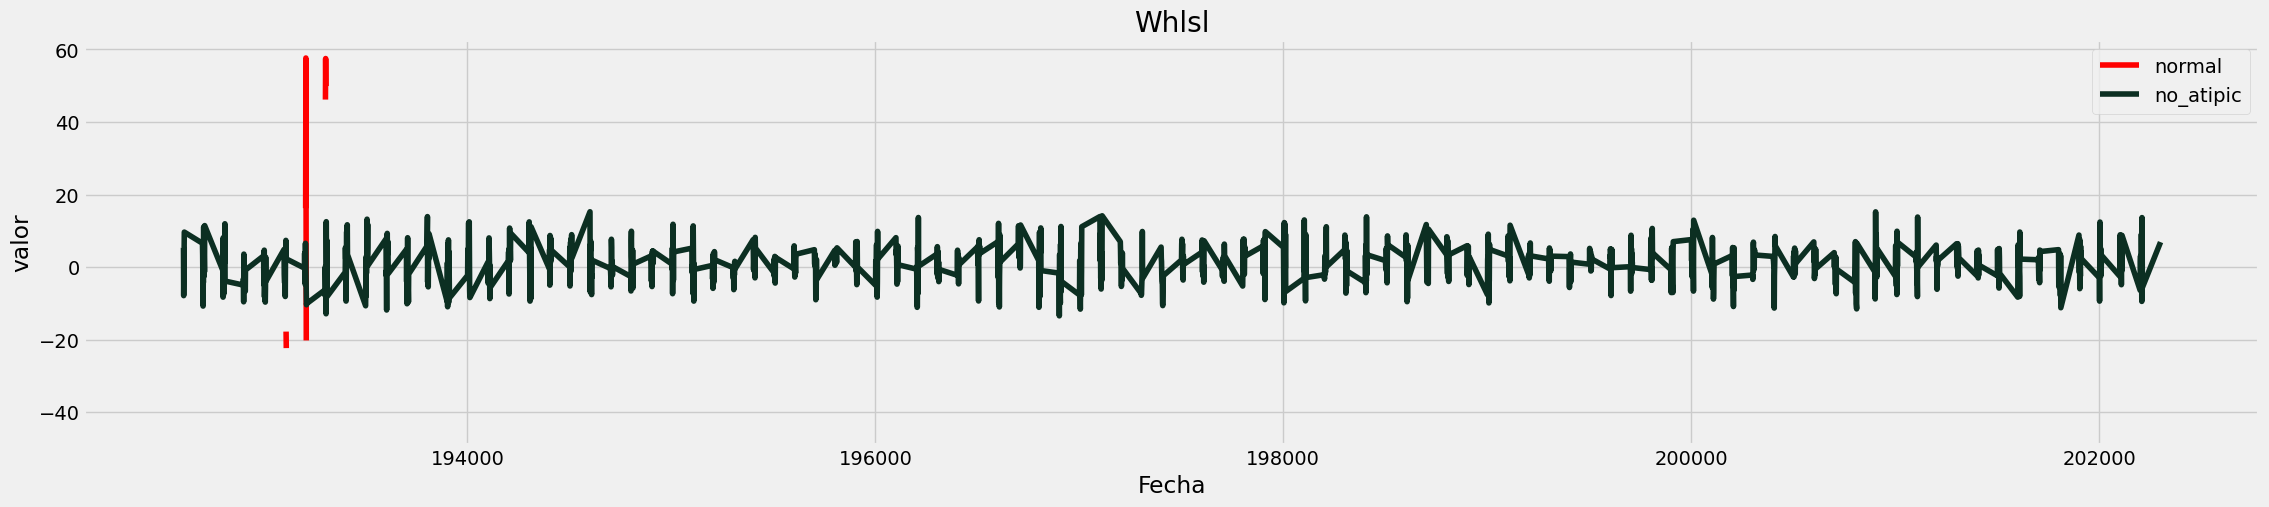

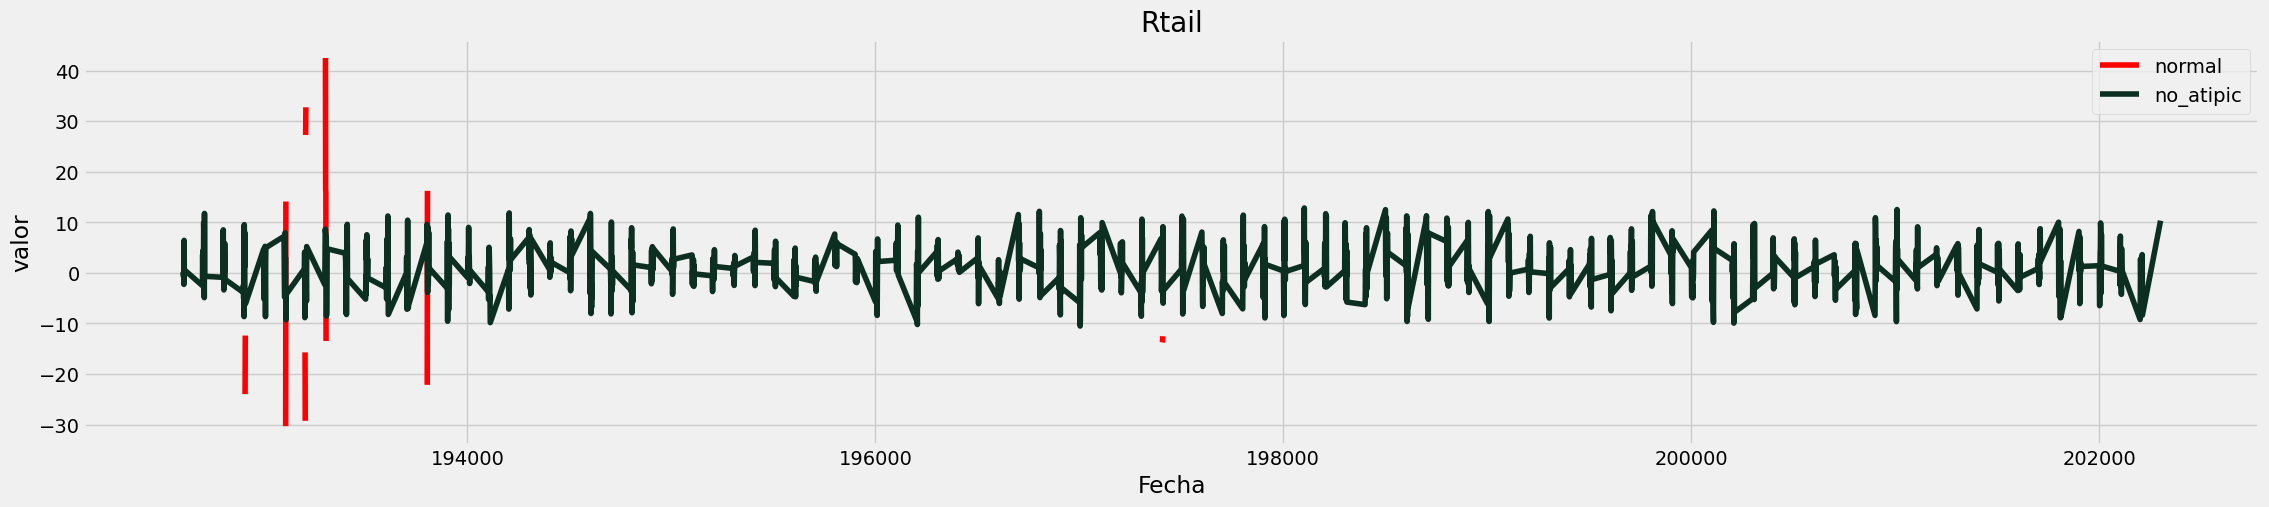

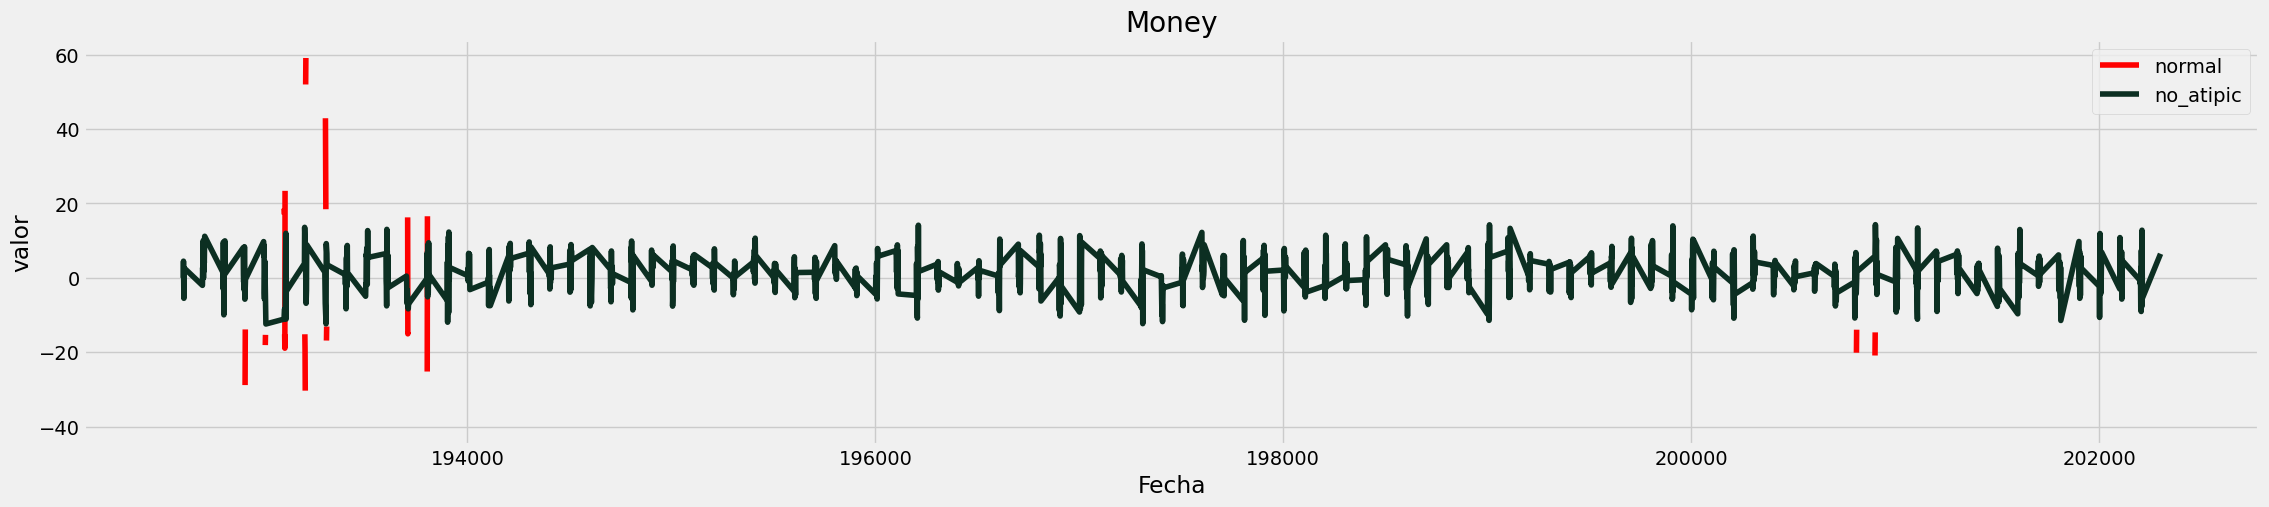

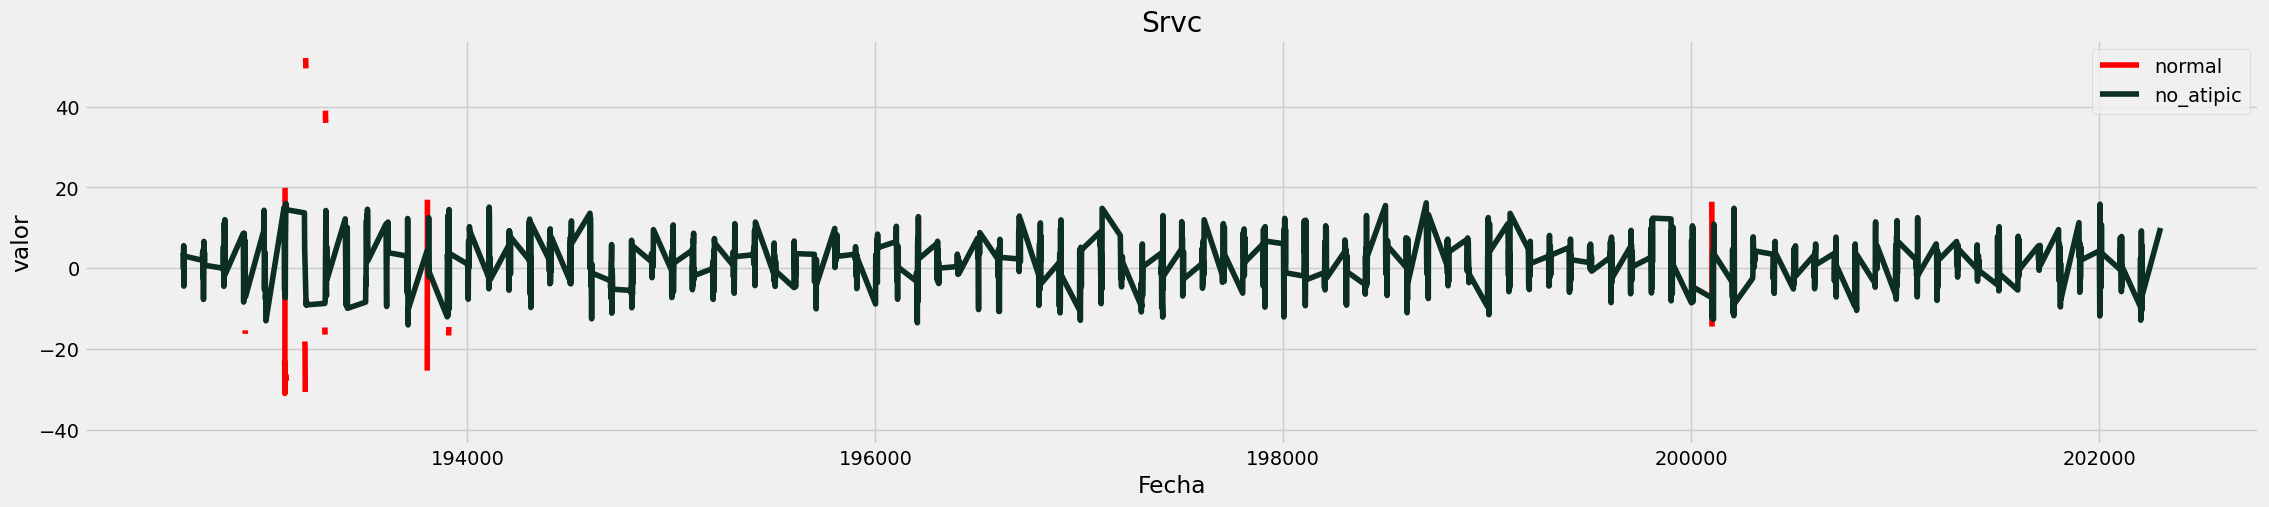

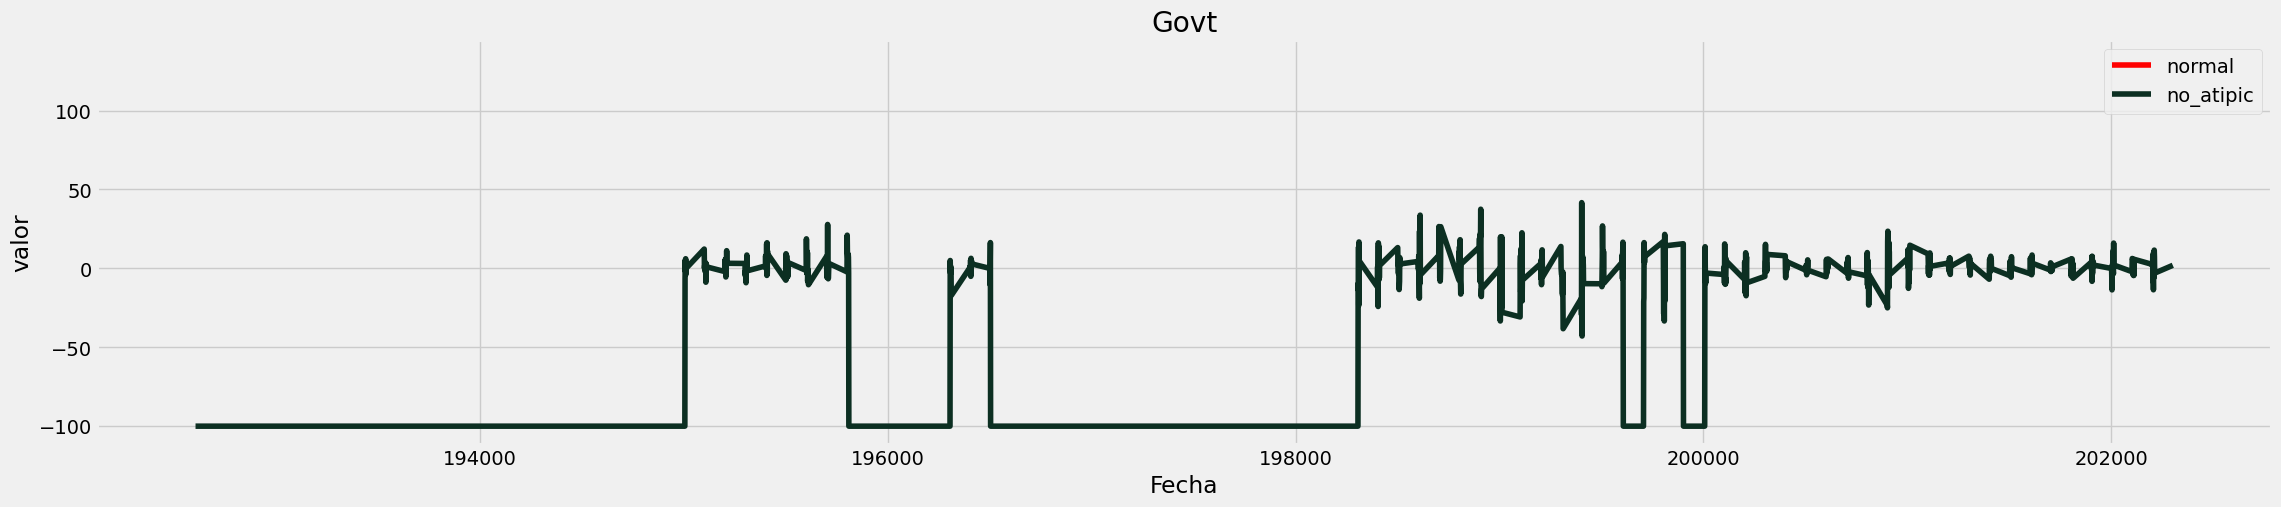

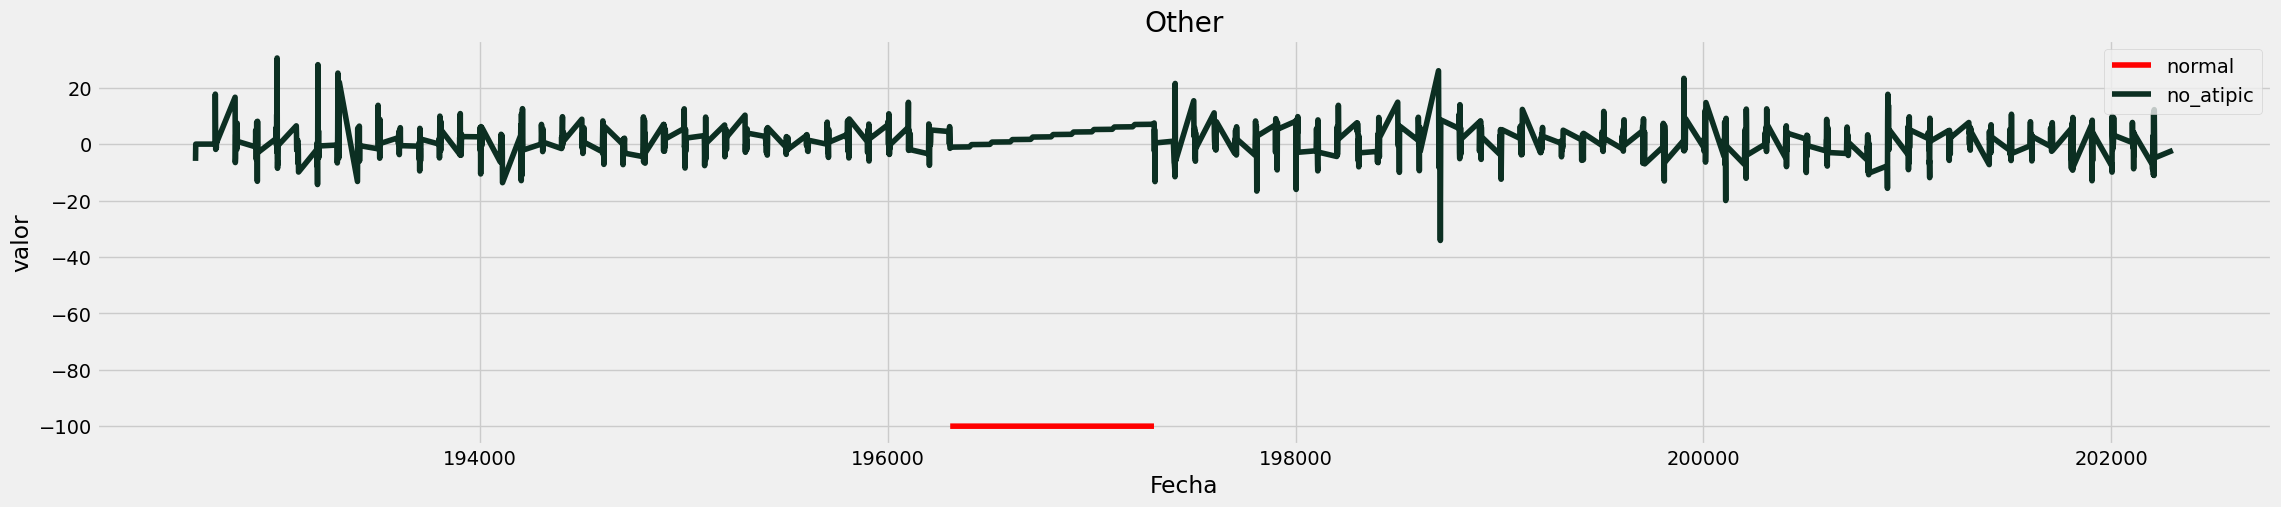

In [16]:
# Importar data
data38_OG = pd.read_excel(ROOT_PATH +"/data/portfolio/input/raw/data38.xlsx").set_index('date')

# Volver la data binaria
binary = False
data38 = transform_data(data38_OG.copy(), binary)

# Detectar atípicos
outliers = data38.apply(detect_outliers)

# Calcular la cantidad de outliers en cada columna
prop_outliers_vble = outliers.sum(axis = 0)
prop_outliers_date = outliers.sum(axis = 1)

# Saco dos df, con y sin outliers
outlier_df, df_nooutlier =  df_outlier(outliers.copy(), data38_OG.copy())

# Gráficar salidas con outliers
plot_grapfh(outlier_df, df_nooutlier)

In [15]:
alpha = pd.DataFrame(prop_outliers_date)
alpha.sort_values(by=[0], ascending= False)

0
date      
193304  32
193109  32
198710  31
193803  31
194005  31
...     ..
197609   0
197610   0
197611   0
197612   0
193406   0

[1159 rows x 1 columns]

# Covarianza

##### Calcular la matriz de covarianzas

In [103]:
cov_matrix = np.cov(data38_OG.T)
cond_num = np.linalg.eigvals(cov_matrix)
cond_num = np.sort(cond_num)[::-1]
cond_number = cond_num[0] / cond_num[-1]
print("-"*17)
print("Número condición de la matriz de covarianzas:", cond_number)
print("-"*17)


-----------------
Número condición de la matriz de covarianzas: 1368.494259473167
-----------------


##### Para reducir el número condición de la matriz de covarianzas, podemos utilizar técnicas de regularización. Una forma común de regularización es agregar un término de regularización a la matriz de covarianzas, lo que reduce la magnitud de los valores propios más grandes y mejora el número condición.

##### En este ejemplo, agregamos un término de regularización igual a 0.1 veces la matriz identidad multiplicada por el número de columnas de la matriz de covarianzas. Este término de regularización aumenta la diagonal de la matriz de covarianzas en un factor constante, lo que reduce el número condición. Al ajustar el valor de la constante de regularización, podemos encontrar un equilibrio entre mejorar el número condición y mantener la calidad de los datos.

In [104]:
# Regularizar la matriz de covarianzas
cov_mat_reg = cov_matrix + 0.1*np.identity(cov_matrix.shape[0])
cond_num_reg = np.linalg.cond(cov_mat_reg)

print("-"*17)
print("Número condición de la matriz de covarianzas regularizada:", cond_num_reg)
print("-"*17)

-----------------
Número condición de la matriz de covarianzas regularizada: 1325.6003672261263
-----------------


##### Otra forma de reducir el número condición de la matriz de covarianzas es aplicar una técnica de reducción de dimensionalidad, como Análisis de Componentes Principales (PCA). PCA reduce el número de dimensiones de la base de datos al proyectar los datos en un espacio de menor dimensión que conserva la mayor parte de la varianza en los datos. Esto puede ayudar a reducir el número condición de la matriz de covarianzas y mejorar la calidad de los datos.

##### En este ejemplo, utilizamos la implementación de PCA en la biblioteca scikit-learn para reducir las dimensiones de la base de datos a 2 componentes principales. Luego, calculamos la matriz de covarianzas de los datos transformados y el número condición correspondiente. Notamos que en comparación con la matriz de covarianzas original, la matriz de covarianzas de los datos transformados tiene un número condición mucho menor, lo que indica una mayor estabilidad numérica.

In [126]:
# Reducción de dimensionalidad utilizando PCA
from sklearn.decomposition import PCA

# Instanciar PCA con número de componentes igual a 10
pca = PCA(n_components=25)

# Ajustar y transformar los datos a las nuevas dimensiones
data_pca = pca.fit_transform(data38_OG.copy())

# Calcular matriz de covarianzas y número condición de los datos transformados
cov_mat_pca = np.cov(data_pca.T)
cond_num_pca = np.linalg.cond(cov_mat_pca)

print("Número condición de la matriz de covarianzas de los datos transformados:", cond_num_pca)

Número condición de la matriz de covarianzas de los datos transformados: 337.3378797736535
